In [3]:
!pip install Flask

In [4]:
# --- DEBUGGING INITIAL DATA ---
print(f"DEBUG: Shape of df_original (after loading): {df_original.shape if 'df_original' in locals() else 'Not found'}")
print(f"DEBUG: Shape of df_cleaned_overall (after initial cleaning): {df_cleaned_overall.shape if 'df_cleaned_overall' in locals() else 'Not found'}")
if 'df_cleaned_overall' in locals() and not df_cleaned_overall.empty:
    print(f"DEBUG: df_cleaned_overall min date: {df_cleaned_overall.index.min()}")
    print(f"DEBUG: df_cleaned_overall max date: {df_cleaned_overall.index.max()}")
    print(f"DEBUG: df_cleaned_overall columns: {df_cleaned_overall.columns.tolist()}")
    if intensity_column_name not in df_cleaned_overall.columns:
        print(f"ERROR: intensity_column_name '{intensity_column_name}' not found in df_cleaned_overall columns!")
else:
    print("ERROR: df_cleaned_overall is not available or is empty early in the script.")

print(f"DEBUG: last_historical_date: {last_historical_date if 'last_historical_date' in locals() else 'Not found'}")
print(f"DEBUG: forecast_end_date_overall: {forecast_end_date_overall if 'forecast_end_date_overall' in locals() else 'Not found'}")
# --- END DEBUGGING INITIAL DATA ---

DEBUG: Shape of df_original (after loading): Not found
DEBUG: Shape of df_cleaned_overall (after initial cleaning): Not found
ERROR: df_cleaned_overall is not available or is empty early in the script.
DEBUG: last_historical_date: Not found
DEBUG: forecast_end_date_overall: Not found


In [5]:
# --- 1. Import Libraries ---

# Thư viện cơ bản và xử lý dữ liệu
import pandas as pd
import numpy as np
import os
import sys # Để thoát chương trình
import re # Để xử lý regex, nếu cần trong tương lai
import pickle # Để lưu và tải scaler/model
from datetime import datetime, timedelta, date # date được thêm từ phần sau
from PIL import Image # Dành cho việc xử lý ảnh, ví dụ để tạo GIF

# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt

# Thư viện cho Prophet
from prophet import Prophet

# Thư viện cho LSTM (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping ở đây
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score, roc_auc_score # Thêm các metrics từ phần sau

# Thư viện cho PatchTST (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset # TensorDataset được thêm từ phần sau
import torch.optim as optim
from sklearn.preprocessing import StandardScaler # StandardScaler được dùng cho PatchTST

print("Libraries imported successfully!")

# THAY ĐỔI: Định nghĩa device ở phạm vi toàn cục
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")


2025-06-21 08:37:31.037332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750495051.199062      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750495051.245066      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!
Sử dụng thiết bị: cuda


In [6]:
# --- 2. Install necessary libraries for PatchTST (if not already installed on Kaggle) ---
print("Attempting to install 'tqdm' for progress bars (common in DL training)...")
try:
    import tqdm
except ImportError:
    !pip install tqdm
    import tqdm
print("Installation checks complete!")

Attempting to install 'tqdm' for progress bars (common in DL training)...
Installation checks complete!


In [7]:
# --- 3. Load and Preprocess Data ---
# Đường dẫn đến bộ dữ liệu Kaggle đã thêm vào
dataset_path = "/kaggle/input/digital-typhoon-dataset-wp-gifs/"
output_dir = "/kaggle/working/" # Thư mục để lưu file CSV tổng

# --- CẤU HÌNH CÁC NĂM MUỐN DỰ BÁO VÀ HIỂN THỊ TRONG BÁO CÁO ---
forecast_years = list(range(2026, 2031))
print(f"Dự báo sẽ được tạo cho các năm: {forecast_years}")
# forecast_end_date_overall now defines the end of the *test set*
forecast_end_date_overall = pd.to_datetime(f'{max(forecast_years)}-12-31')

# --- LOGIC MỚI: HỢP NHẤT TẤT CẢ CÁC FILE CSV VÀ TẠO FILE TỔNG VỚI CỘT THỜI GIAN ĐÃ GHÉP ---
# We'll now have a historical combined CSV and potentially a future test CSV
combined_historical_csv_path = os.path.join(output_dir, "combined_typhoon_historical_data.csv")
combined_future_test_csv_path = os.path.join(output_dir, "combined_typhoon_future_test_data.csv")

all_dataframes_raw = [] # Will store raw dataframes before any resampling
common_intensity_cols = ['usa_wind', 'wind', 'vmax', 'intensity_kt', 'wmo_wind', 'max_sustained_wind']

print(f"\nSearching and combining all suitable CSV files from: {dataset_path}")

found_any_data = False

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            file_name_only = os.path.basename(file)
            print(f"  Processing: {file_path}")
            try:
                df_temp = pd.read_csv(file_path, skipinitialspace=True, low_memory=False)
                df_temp.columns = df_temp.columns.str.strip().str.lower()
                
                missing_time_cols = [col for col in ['year', 'month', 'day', 'hour'] if col not in df_temp.columns]
                if missing_time_cols:
                    print(f"    -> Skipped {file_name_only}: Missing one or more of required time columns: {missing_time_cols}")
                else:
                    df_temp['time'] = pd.to_datetime(df_temp[['year', 'month', 'day', 'hour']], errors='coerce')
                    initial_rows = len(df_temp)
                    df_temp = df_temp.dropna(subset=['time'])
                    rows_after_time_dropna = len(df_temp)

                    current_intensity_col = None
                    for col in common_intensity_cols:
                        if col in df_temp.columns:
                            current_intensity_col = col
                            break
                    
                    if df_temp.empty:
                        print(f"    -> Skipped {file_name_only}: All rows dropped due to invalid 'time' data (initial rows: {initial_rows}, after dropping invalid time: {rows_after_time_dropna}).")
                    elif not current_intensity_col:
                        print(f"    -> Skipped {file_name_only}: No suitable intensity column found among {common_intensity_cols}.")
                    else:
                        df_temp['source_file'] = file_name_only
                        
                        if current_intensity_col != 'intensity_kt':
                            df_temp.rename(columns={current_intensity_col: 'intensity_kt'}, inplace=True)
                        
                        cols_to_drop_time = [col for col in ['year', 'month', 'day', 'hour'] if col in df_temp.columns]
                        
                        # Keep all columns (excluding original time columns)
                        df_to_append = df_temp.drop(columns=cols_to_drop_time, errors='ignore').copy()

                        all_dataframes_raw.append(df_to_append)
                        found_any_data = True
                        print(f"    -> Added {len(df_to_append)} rows from {file_name_only} (Combined year/month/day/hour, using '{current_intensity_col}', kept all other columns and 'source_file').")

            except Exception as e:
                print(f"    -> Could not read or process {file_path}: {e}")

df_combined_historical = pd.DataFrame() # This will be the full historical data

if all_dataframes_raw:
    print("\nConcatenating all collected raw dataframes for historical data...")
    # Concatenate all raw dataframes. Do NOT drop duplicates by 'time' as per requirement.
    df_combined_historical = pd.concat(all_dataframes_raw, ignore_index=True)
    df_combined_historical = df_combined_historical.sort_values(by='time')
    
    # Set 'time' as index
    df_combined_historical = df_combined_historical.set_index('time')

    # Convert numeric columns and handle NaNs for historical data
    # Identify numeric columns including the renamed 'intensity_kt'
    numeric_cols_historical = df_combined_historical.select_dtypes(include=np.number).columns.tolist()
    
    # Apply to_numeric on identified numeric columns
    for col in numeric_cols_historical:
        if col in df_combined_historical.columns:
            df_combined_historical[col] = pd.to_numeric(df_combined_historical[col], errors='coerce')
    
    # Drop rows where critical numeric columns are NaN (e.g., intensity_kt)
    # You might want to be more specific here if certain NaNs are acceptable in historical data
    df_combined_historical = df_combined_historical.dropna(subset=['intensity_kt'])
    
    # Fill remaining NaNs for other numeric columns if desired (e.g., mean, median, 0, or ffill/bfill)
    # For now, let's keep them if they exist, or drop them if they are not critical.
    # If other numeric columns are important for models, consider more robust imputation.
    # df_combined_historical = df_combined_historical.ffill().bfill() # Be careful, this can spread data

    # Ensure source_file column is handled (it's already string/object)
    if 'source_file' in df_combined_historical.columns:
        # If there are any NaNs in source_file after concat (unlikely if added per row)
        # We can fill them with a placeholder if needed, but no resampling here.
        if df_combined_historical['source_file'].isnull().any():
             print("INFO: Found NaNs in 'source_file' in historical data. Filling with 'unknown_source_hist'.")
             df_combined_historical['source_file'].fillna('unknown_source_hist', inplace=True)

    # Save combined historical DataFrame
    if not df_combined_historical.empty:
        df_combined_historical.to_csv(combined_historical_csv_path, index=True)
        print(f"Successfully combined and saved historical data to: {combined_historical_csv_path}")
        print(f"Total rows in combined historical CSV: {len(df_combined_historical)}")
        print(f"Columns in combined historical CSV: {df_combined_historical.columns.tolist()}")
        print(f"Data types in combined historical CSV:\n{df_combined_historical.dtypes}")
    else:
        print("Combined historical DataFrame is empty after processing. Skipping saving to CSV.")
        found_any_data = False

else:
    print("\nNo suitable CSV files found or processed from the dataset for historical data. Cannot proceed without data.")
    found_any_data = False
    sys.exit(1) # Exit if no historical data

# --- Tải dữ liệu từ file CSV tổng đã tạo (historical) ---
df_for_patchtst = pd.DataFrame()
target_series = pd.Series()
intensity_column_name = 'intensity_kt'

if found_any_data and os.path.exists(combined_historical_csv_path) and not df_combined_historical.empty:
    try:
        print(f"\nLoading data from combined historical CSV: {combined_historical_csv_path}")
        df_loaded_historical = pd.read_csv(combined_historical_csv_path, index_col='time', parse_dates=True, skipinitialspace=True, low_memory=False)
        
        # Ensure intensity_kt column exists (should be handled during initial merge)
        if 'intensity_kt' not in df_loaded_historical.columns:
            # This case should ideally not happen if initial processing was correct
            # Re-check for common intensity cols and rename if necessary
            found_intensity_col = None
            for col in common_intensity_cols:
                if col in df_loaded_historical.columns:
                    found_intensity_col = col
                    break
            if found_intensity_col:
                intensity_column_name = found_intensity_col
                print(f"Warning: 'intensity_kt' not found in historical CSV after loading. Using '{intensity_column_name}'.")
                df_loaded_historical.rename(columns={found_intensity_col: 'intensity_kt'}, inplace=True)
                intensity_column_name = 'intensity_kt'
            else:
                raise ValueError("No 'intensity_kt' or other suitable intensity column found in historical CSV after loading.")
        
        df_for_patchtst = df_loaded_historical.copy() # This is your primary historical data source
        target_series = df_for_patchtst[intensity_column_name].dropna()

        print(f"\nSuccessfully loaded and processed historical data from combined CSV.")
        print(f"Using '{intensity_column_name}' as the primary intensity column.")
        print(f"Processed historical data for PatchTST (first 5 rows):")
        print(df_for_patchtst.head())
        print(f"Total historical data points for PatchTST: {len(df_for_patchtst)}")
        print(f"Total historical data points for Prophet/LSTM ({intensity_column_name}): {len(target_series)}")

    except Exception as e:
        print(f"\nError loading or processing combined historical CSV from {combined_historical_csv_path}: {e}")
        print("Fatal error: Cannot proceed without valid historical data.")
        sys.exit(1)
else:
    print("\nFatal error: No combined historical CSV found or it is empty after initial processing. Cannot proceed without data.")
    sys.exit(1)

# --- CHUẨN BỊ DỮ LIỆU CHUNG CHO DỰ BÁO DÀI HẠN VÀ TẠO TEST SET ---

# Define the current date (end of historical data to be used for training)
current_datetime = pd.Timestamp('2024-12-31 23:59:59') # Fixed current date for consistent results

# Ensure historical data doesn't go into the future
last_historical_date_in_data = df_for_patchtst.index.max()
if last_historical_date_in_data > current_datetime:
    print(f"Clipping historical data. Last data point was {last_historical_date_in_data}, but setting end to {current_datetime}")
    df_for_patchtst = df_for_patchtst[df_for_patchtst.index <= current_datetime].copy()
    target_series = target_series[target_series.index <= current_datetime].copy()
    # Re-check max date after clipping
    last_historical_date_in_data = df_for_patchtst.index.max()


print(f"\nLast historical data point for training/validation: {last_historical_date_in_data}")

# --- TẠO TẬP DỮ LIỆU TEST TỪ 2024 ĐẾN 2030 (6H MỘT LẦN) ---
# Start from 2024-01-01 if historical data goes earlier, or from last_historical_date_in_data + 6h
# If current_datetime is 2024-12-31, then the test set starts from 2025-01-01 00:00:00
test_start_date = current_datetime + pd.Timedelta(hours=6) # Start immediately after historical data ends

print(f"\nGenerating future test set from {test_start_date} to {forecast_end_date_overall} at 6-hour intervals.")

# Create the date range for the future test set
future_dates = pd.date_range(start=test_start_date, end=forecast_end_date_overall, freq='6h')

# Initialize future_test_df with just the 'time' index
df_future_test = pd.DataFrame(index=future_dates)

# Add all relevant columns found in historical data to the future test set
# These will be NaNs initially, as they are for future predictions
for col in df_for_patchtst.columns:
    if col != 'source_file': # source_file is not a feature for forecasting
        df_future_test[col] = np.nan # Initialize with NaN for prediction

# If 'source_file' is desired in the future test set, you'd need a rule for it.
# For now, it's typically not a feature used in forecasting the future.

# Save the future test set (can be empty values for now, will be filled by models)
if not df_future_test.empty:
    df_future_test.to_csv(combined_future_test_csv_path, index=True)
    print(f"Successfully generated and saved future test data to: {combined_future_test_csv_path}")
    print(f"Total rows in future test CSV: {len(df_future_test)}")
    print(f"Columns in future test CSV: {df_future_test.columns.tolist()}")
    print(f"Data types in future test CSV:\n{df_future_test.dtypes}")
else:
    print("Future test DataFrame is empty. Skipping saving to CSV.")

print("\nData loading and preprocessing complete.")
print("Historical data (df_for_patchtst) is ready for training/validation (no 6h resampling).")
print("Future test data (df_future_test) is generated at 6h intervals for predictions.")

Dự báo sẽ được tạo cho các năm: [2026, 2027, 2028, 2029, 2030]

Searching and combining all suitable CSV files from: /kaggle/input/digital-typhoon-dataset-wp-gifs/
  Processing: /kaggle/input/digital-typhoon-dataset-wp-gifs/metadata/metadata/198129.csv
    -> Added 169 rows from 198129.csv (Combined year/month/day/hour, using 'wind', kept all other columns and 'source_file').
  Processing: /kaggle/input/digital-typhoon-dataset-wp-gifs/metadata/metadata/199521.csv
    -> Added 193 rows from 199521.csv (Combined year/month/day/hour, using 'wind', kept all other columns and 'source_file').
  Processing: /kaggle/input/digital-typhoon-dataset-wp-gifs/metadata/metadata/200607.csv
    -> Added 259 rows from 200607.csv (Combined year/month/day/hour, using 'wind', kept all other columns and 'source_file').
  Processing: /kaggle/input/digital-typhoon-dataset-wp-gifs/metadata/metadata/200002.csv
    -> Added 169 rows from 200002.csv (Combined year/month/day/hour, using 'wind', kept all other colu

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
# --- 4. Cấu hình môi trường và Tải dữ liệu GIF---
# Đường dẫn mặc định của Kaggle cho dataset đã thêm
# Đã cập nhật để trỏ đến thư mục 512x512 cụ thể
GIF_DATA_FOLDER = '/kaggle/input/digital-typhoon-dataset-wp-gifs/128_x_128/128_x_128/'
# Đường dẫn đến file CSV tổng hợp (theo yêu cầu của bạn)
COMBINED_CSV_PATH = '/kaggle/working/combined_typhoon_historical_data.csv' 

print(f"Kiểm tra thư mục dữ liệu GIF: {GIF_DATA_FOLDER}")
if not os.path.exists(GIF_DATA_FOLDER):
    print("Lỗi: Không tìm thấy thư mục dữ liệu GIF. Đảm bảo bạn đã thêm dataset vào notebook của mình.")
    # THAY ĐỔI: Dừng chương trình nếu không tìm thấy thư mục GIF
    sys.exit("Không tìm thấy thư mục dữ liệu GIF. Chương trình không thể tiếp tục mà không có dữ liệu hình ảnh.")
else:
    gif_files_in_folder = [f for f in os.listdir(GIF_DATA_FOLDER) if f.endswith('.gif')]
    if not gif_files_in_folder:
        sys.exit("Thư mục dữ liệu GIF rỗng hoặc không chứa file .gif nào. Chương trình không thể tiếp tục.")
    print(f"Tìm thấy {len(gif_files_in_folder)} file GIF trong thư mục.")
    print(f"Một vài file đầu tiên: {gif_files_in_folder[:5]}...") # In ra vài file đầu tiên

# THAY ĐỔI: Tải file CSV tổng hợp
print(f"Kiểm tra file CSV tổng hợp: {COMBINED_CSV_PATH}")
if not os.path.exists(COMBINED_CSV_PATH):
    sys.exit(f"Lỗi: Không tìm thấy file CSV tổng hợp tại {COMBINED_CSV_PATH}. Chương trình không thể tiếp tục.")

try:
    combined_df_raw = pd.read_csv(COMBINED_CSV_PATH)
    # Đảm bảo cột 'time' là datetime và 'source_file' là string
    combined_df_raw['time'] = pd.to_datetime(combined_df_raw['time'])
    combined_df_raw['source_file'] = combined_df_raw['source_file'].astype(str)
    print("File CSV tổng hợp đã được tải thành công.")
    print(f"Kích thước file CSV tổng hợp: {combined_df_raw.shape}")
    print(combined_df_raw.head())
except Exception as e:
    sys.exit(f"Lỗi khi tải hoặc tiền xử lý file CSV tổng hợp: {e}. Chương trình không thể tiếp tục.")


def load_and_preprocess_gif_data_kaggle(gif_folder, combined_csv_df, image_size=(128, 128), num_features=64):
    """
    Hàm để tải và tiền xử lý dữ liệu GIF từ Kaggle, trích xuất các đặc trưng thành chuỗi thời gian.
    Các timestamp được gán dựa trên thông tin thời gian từ file CSV tổng hợp.

    LƯU Ý VỀ XỬ LÝ GPU:
    Thư viện PIL (Pillow) được sử dụng ở đây để đọc và resize ảnh là tác vụ CPU-bound.
    Để thực sự tận dụng GPU cho xử lý ảnh ở quy mô lớn (>1100 GIF files), bạn sẽ cần một pipeline khác:
    1. Đọc ảnh bằng PIL (vẫn trên CPU).
    2. Chuyển đổi ảnh PIL sang torch.Tensor và gửi Tensor đó lên GPU: `torchvision.transforms.ToTensor()(pil_image).to(device)`.
    3. Thực hiện các phép biến đổi ảnh (resize, grayscale, normalize) trực tiếp trên GPU bằng các phép toán của PyTorch
       hoặc torchvision.transforms (nếu chúng hỗ trợ GPU cho loại dữ liệu của bạn).
    4. Đặc biệt, nếu bạn cần trích xuất đặc trưng ý nghĩa (ví dụ: từ hình thái bão), hãy sử dụng một
       mô hình Convolutional Neural Network (CNN) tiền huấn luyện (ví dụ: ResNet, VGG từ `torchvision.models`).
       Mô hình này sẽ chạy trên GPU và trích xuất các vector đặc trưng mạnh mẽ từ ảnh.
       Việc trích xuất đặc trưng bằng CNN trên GPU sẽ mang lại hiệu quả lớn nhất.
    Với phương pháp trích xuất đặc trưng hiện tại (trung bình pixel và giá trị ngẫu nhiên),
    việc chuyển sang GPU sẽ không mang lại lợi ích đáng kể vì bản thân các phép toán rất đơn giản
    và bottleneck nằm ở việc đọc/giải mã file GIF và các phép toán cơ bản của Python/NumPy.

    CÁC PHƯƠNG PHÁP ĐỂ XỬ LÝ GIF NHANH HƠN CHO HUẤN LUYỆN:
    1. Tiền xử lý và Lưu trữ: Trích xuất các đặc trưng từ tất cả các GIF một lần và lưu trữ chúng
       vào một định dạng file hiệu quả (như HDF5, Feather, Parquet) hoặc một cơ sở dữ liệu (ví dụ SQLite).
       Sau đó, trong các lần huấn luyện tiếp theo, chỉ cần tải các đặc trưng đã xử lý thay vì xử lý lại GIF.
    2. Giảm kích thước ảnh đầu vào: Giảm `image_size` sẽ làm giảm thời gian xử lý ảnh.
    3. Trích xuất đặc trưng hiệu quả: Nếu dùng CNN, đảm bảo mô hình được tối ưu hóa và chạy trên GPU.
    4. Xử lý song song: Sử dụng `multiprocessing` để xử lý GIF trên nhiều core CPU nếu bottleneck là CPU.

    Args:
        gif_folder (str): Đường dẫn đến thư mục chứa các file GIF trên Kaggle.
        combined_csv_df (pd.DataFrame): DataFrame chứa dữ liệu từ combined_typhoon_data.csv.
        image_size (tuple): Kích thước ảnh muốn thay đổi.
        num_features (int): Số lượng đặc trưng muốn trích xuất cho mỗi khung hình.

    Returns:
        pd.DataFrame: DataFrame chứa chuỗi thời gian các đặc trưng.
                      Cột đầu tiên là 'ds' (timestamp), các cột còn lại là các đặc trưng.
    """
    all_series_data = []
    gif_files = [f for f in os.listdir(gif_folder) if f.endswith('.gif')]
    gif_files.sort() # Sắp xếp để đảm bảo thứ tự thời gian

    print(f"Bắt đầu xử lý {len(gif_files)} file GIF...")

    # Regex để phân tích tên file GIF theo định dạng YYYYDDD_...gif
    # Ví dụ: 201319_512_x_512.gif -> 201319 là tiền tố source_file
    filename_pattern = re.compile(r'(\d{6})_.*\.gif')

    processed_gif_count = 0

    for idx, gif_file in enumerate(gif_files):
        gif_path = os.path.join(gif_folder, gif_file)
        match = filename_pattern.match(gif_file)

        if not match:
            print(f"WARNING: Không thể phân tích tên file GIF: {gif_file}. Bỏ qua file này.")
            continue
        
        source_file_prefix = match.group(1) # Lấy YYYYDDD từ tên file
        
        # Lọc dữ liệu trong combined_csv_df theo tiền tố source_file
        relevant_entries = combined_csv_df[combined_csv_df['source_file'].str.startswith(source_file_prefix, na=False)]

        if relevant_entries.empty:
            print(f"WARNING: Không tìm thấy thông tin thời gian trong CSV cho tiền tố source_file '{source_file_prefix}' (từ file {gif_file}). Bỏ qua file này.")
            continue
        
        min_time_for_gif = relevant_entries['time'].min()
        max_time_for_gif = relevant_entries['time'].max()

        try:
            img = Image.open(gif_path)
            frames_features = []
            timestamps = []
            
            num_frames = img.n_frames
            
            # Tính toán khoảng thời gian giữa các frame
            if num_frames > 1:
                time_interval = (max_time_for_gif - min_time_for_gif) / (num_frames - 1)
            else:
                time_interval = timedelta(seconds=0) # Nếu chỉ có 1 frame, không có khoảng cách

            for i in range(num_frames):
                img.seek(i)
                frame = img.convert('L').resize(image_size) # Chuyển sang grayscale và resize

                # --- VÍ DỤ TRÍCH XUẤT ĐẶC TRƯNG ĐƠN GIẢN (THAY THẾ PHẦN NÀY) ---
                feature_vector = [np.mean(np.array(frame))] + list(np.random.rand(num_features - 1))
                # --- HẾT VÍ DỤ TRÍCH XUẤT ĐẶC TRƯNG ĐƠN GIẢN ---

                timestamps.append(min_time_for_gif + i * time_interval)
                frames_features.append(feature_vector)
            
            gif_df = pd.DataFrame({'ds': timestamps})
            for j in range(num_features):
                gif_df[f'feature_{j}'] = [f[j] for f in frames_features]
            all_series_data.append(gif_df)
            processed_gif_count += 1

        except Exception as e:
            print(f"Lỗi khi xử lý file {gif_file}: {e}. Bỏ qua file này.")
            continue

    if not all_series_data:
        # THAY ĐỔI: Dừng chương trình nếu không có dữ liệu nào được xử lý
        sys.exit("Không có dữ liệu GIF nào được xử lý thành công. Chương trình không thể tiếp tục.")

    df_combined = pd.concat(all_series_data).reset_index(drop=True)
    df_combined = df_combined.sort_values(by='ds').reset_index(drop=True)
    df_combined.drop_duplicates(subset=['ds'], inplace=True) # Loại bỏ trùng lặp nếu có
    
    df_combined = df_combined[['ds'] + [col for col in df_combined.columns if col != 'ds']] # Đảm bảo 'ds' là cột đầu tiên
    print(f"Tổng cộng {processed_gif_count} file GIF đã được xử lý thành công.")
    return df_combined

# THAY ĐỔI: Gọi hàm load_and_preprocess_gif_data_kaggle với combined_df_raw
df = load_and_preprocess_gif_data_kaggle(GIF_DATA_FOLDER, combined_csv_df=combined_df_raw, num_features=64)

# THAY ĐỔI: Dừng chương trình nếu df rỗng sau khi xử lý GIF
if df.empty:
    sys.exit("DataFrame 'df' rỗng sau khi xử lý GIF. Không có dữ liệu để huấn luyện mô hình.")

print("Dữ liệu chuỗi thời gian đã chuẩn bị:")
print(df.head())
print(f"Kích thước dữ liệu: {df.shape}")
print(f"Các cột dữ liệu: {df.columns.tolist()}")
num_features = df.shape[1] - 1 # Cập nhật lại số lượng đặc trưng dựa trên dữ liệu đã load/tạo

# --- THAY ĐỔI: Chia tập huấn luyện và kiểm tra theo yêu cầu 1978-2023 ---
# Huấn luyện từ 1978 đến hết 2023. Đánh giá trên phần còn lại (ví dụ 2024 trở đi)
train_end_date = pd.to_datetime('2023-12-31 23:59:59') # Kết thúc năm 2023

# Lấy dữ liệu huấn luyện
train_df = df[df['ds'] <= train_end_date].copy()
test_df = df[df['ds'] > train_end_date].copy()

# Kiểm tra nếu train_df hoặc test_df rỗng
if train_df.empty:
    sys.exit("Tập huấn luyện rỗng. Đảm bảo dữ liệu GIF có các mốc thời gian từ 1978 đến 2023.")
if test_df.empty:
    print("CẢNH BÁO: Tập kiểm tra rỗng. Không thể đánh giá mô hình trên dữ liệu chưa thấy. Chương trình sẽ tiếp tục nhưng không có đánh giá chính xác.")
    # Để tránh lỗi, tạo một test_df giả định từ train_df nếu test_df thực sự rỗng
    if len(train_df) > 100:
        test_df = train_df.tail(100).copy()
    else:
        test_df = pd.DataFrame(columns=df.columns) # Tạo DataFrame rỗng với đúng cột

print(f"Kích thước tập huấn luyện (đến 2023): {train_df.shape}")
print(f"Kích thước tập kiểm tra (sau 2023): {test_df.shape}")

# Ngày bắt đầu dự báo (sau tập huấn luyện)
forecast_start_date = train_df['ds'].max() + pd.Timedelta(minutes=10) # Bắt đầu ngay sau train_df
forecast_end_date = pd.to_datetime('2030-12-31 23:59:59') # Dự báo đến cuối năm 2030

# Tính toán tổng số bước thời gian cần dự báo
# Tần số dữ liệu là 10 phút, tức 6 điểm/giờ, 144 điểm/ngày
time_delta_forecast = (forecast_end_date - forecast_start_date)
total_minutes_forecast = time_delta_forecast.total_seconds() / 60
total_forecast_steps_needed = int(total_minutes_forecast / 10) # Chia cho 10 phút

print(f"Bắt đầu dự báo từ: {forecast_start_date}")
print(f"Kết thúc dự báo vào: {forecast_end_date}")
print(f"Tổng số bước thời gian cần dự báo (10 phút/bước): {total_forecast_steps_needed}")



Kiểm tra thư mục dữ liệu GIF: /kaggle/input/digital-typhoon-dataset-wp-gifs/128_x_128/128_x_128/
Tìm thấy 1116 file GIF trong thư mục.
Một vài file đầu tiên: ['198417_128_x_128.gif', '200406_128_x_128.gif', '201708_128_x_128.gif', '201611_128_x_128.gif', '198308_128_x_128.gif']...
Kiểm tra file CSV tổng hợp: /kaggle/working/combined_typhoon_historical_data.csv
File CSV tổng hợp đã được tải thành công.
Kích thước file CSV tổng hợp: (226532, 18)
                 time  grade    lat     lng  pressure  intensity_kt  dir50  \
0 1978-11-25 12:00:00      2  13.00  154.00    1004.0           0.0      0   
1 1978-11-25 12:00:00      2  13.00  154.00    1004.0           0.0      0   
2 1978-11-25 13:00:00      2  12.98  153.82    1003.7           0.0      0   
3 1978-11-25 13:00:00      2  12.98  153.82    1003.7           0.0      0   
4 1978-11-25 14:00:00      2  12.97  153.64    1003.3           0.0      0   

   long50  short50  dir30  long30  short30  landfall  intp file_1  mask_1  \
0     

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Tổng cộng 1116 file GIF đã được xử lý thành công.
Dữ liệu chuỗi thời gian đã chuẩn bị:
                             ds   feature_0  feature_1  feature_2  feature_3  \
0 1978-11-25 12:00:00.000000000  176.782898   0.986891   0.871892   0.588585   
1 1978-11-28 09:00:00.000000000  171.818604   0.826703   0.567363   0.545152   
2 1978-12-01 06:00:00.000000000  172.657593   0.320181   0.177096   0.157709   
3 1978-12-31 12:00:00.000000000  165.877563   0.838034   0.104030   0.625419   
4 1978-12-31 15:06:25.714285714  157.583618   0.354404   0.651597   0.222036   

   feature_4  feature_5  feature_6  feature_7  feature_8  ...  feature_54  \
0   0.816559   0.197169   0.008388   0.352911   0.329971  ...    0.746036   
1   0.797787   0.775423   0.470826   0.420897   0.286971  ...    0.234970   
2   0.352271   0.420566   0.891151   0.599181   0.570489  ...    0.382375   
3   0.018668   0.985679   0.069875   0.921500   0.335506  ...    0.618457   
4   0.126362   0.363239   0.128220   0.097706  

In [ ]:
# --- 5. Run Prophet Model ---
print("\n--- Running Prophet Model ---")
df_prophet = pd.DataFrame({'ds': target_series.index, 'y': target_series.values})
m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
m.fit(df_prophet)

# Tạo future dataframe kéo dài đến ngày kết thúc dự báo tổng thể
future_prophet_overall = m.make_future_dataframe(periods=int((forecast_end_date_overall - last_historical_date).total_seconds() / (12 * 3600)) + 1, freq='12h')
forecast_prophet_overall = m.predict(future_prophet_overall)
print("Prophet overall forecast completed.")

In [ ]:
# --- 6. Run LSTM Model ---
print("\n--- Running LSTM Model ---")

# Khởi tạo các biến dự báo và cờ thực thi
lstm_forecast = pd.DataFrame() # Đảm bảo lstm_forecast luôn được định nghĩa
lstm_executed = False # Khởi tạo cờ điều khiển

try:
    # Dữ liệu cho LSTM phải là chuỗi thời gian liên tục và chỉ bao gồm cột cường độ
    # Đảm bảo target_series đã được chuẩn bị và không có NaN
    target_series_lstm = target_series.copy().dropna()

    # Giới hạn dữ liệu lịch sử cho LSTM để tránh quá tải và tăng tốc độ huấn luyện
    # Rút gọn số lần thử: Giảm số điểm dữ liệu đầu vào
    # Ví dụ: 50,000 điểm dữ liệu cuối cùng (khoảng 34 năm)
    # Hoặc 20,000 điểm để chạy nhanh hơn nữa
    max_lstm_data_points = 50000 

    if len(target_series_lstm) > max_lstm_data_points:
        print(f"Limiting LSTM data from {len(target_series_lstm)} to {max_lstm_data_points} points for faster training.")
        target_series_lstm = target_series_lstm.tail(max_lstm_data_points)

    if target_series_lstm.empty:
        raise ValueError("LSTM: Target series is empty after preprocessing or limiting data. Cannot run LSTM model.")

    # Scale data
    scaler_lstm = MinMaxScaler(feature_range=(0, 1))
    scaled_data_lstm = scaler_lstm.fit_transform(target_series_lstm.values.reshape(-1, 1))

    # Prepare data for LSTM (create sequences)
    # Giảm time_step để giảm độ phức tạp và tăng tốc độ
    time_step_lstm = 45 # Number of previous time steps to look at (e.g., 45 means 45 * 6 hours = 270 hours = ~11 days)
    
    X_lstm, y_lstm = [], []
    for i in range(len(scaled_data_lstm) - time_step_lstm):
        X_lstm.append(scaled_data_lstm[i:(i + time_step_lstm), 0])
        y_lstm.append(scaled_data_lstm[i + time_step_lstm, 0])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    # Reshape input to be [samples, time_steps, features]
    X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

    # Train-test split (use a specific split point for time series)
    train_size_lstm = int(len(X_lstm) * 0.8)
    X_train_lstm, X_test_lstm = X_lstm[0:train_size_lstm,:], X_lstm[train_size_lstm:len(X_lstm),:]
    y_train_lstm, y_test_lstm = y_lstm[0:train_size_lstm], y_lstm[train_size_lstm:len(y_lstm)]

    print(f"LSTM Train data shape: {X_train_lstm.shape}")
    print(f"LSTM Test data shape: {X_test_lstm.shape}")

    # Build LSTM Model with Dropout
    model_lstm = tf.keras.models.Sequential([
        tf.keras.Input(shape=(time_step_lstm, 1)), # Explicit Input layer
        tf.keras.layers.LSTM(50, return_sequences=True),
        tf.keras.layers.Dropout(0.2), # Dropout layer 1 (20% of neurons are dropped)
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dropout(0.2), # Dropout layer 2
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])

    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    # Add callbacks for early stopping and reducing learning rate
    callbacks_lstm = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), # Tăng patience một chút để mô hình có thêm cơ hội cải thiện
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001) # Tăng patience một chút
    ]

    # Train LSTM Model
    # Rút gọn số lần thử: Giảm số epochs tối đa
    num_epochs_lstm = 50 # Đặt số epochs tối đa. EarlyStopping sẽ tự dừng sớm hơn nếu không cải thiện.
    batch_size_lstm = 128 # Tăng batch_size để đẩy nhanh thời gian huấn luyện trên GPU

    print("Starting LSTM training...")
    history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, 
                                  validation_data=(X_test_lstm, y_test_lstm), 
                                  epochs=num_epochs_lstm, 
                                  batch_size=batch_size_lstm, 
                                  verbose=1,
                                  callbacks=callbacks_lstm)
    print("LSTM training finished.")
    
    # Make predictions
    train_predict_lstm = model_lstm.predict(X_train_lstm)
    
    # Kiểm tra nếu X_test_lstm rỗng trước khi dự đoán
    test_predict_lstm = np.array([]) # Khởi tạo để tránh lỗi nếu test set rỗng
    y_test_lstm_inv = np.array([])
    rmse_lstm = np.nan
    mae_lstm = np.nan

    if X_test_lstm.shape[0] > 0:
        test_predict_lstm = model_lstm.predict(X_test_lstm)
        # Inverse transform predictions and actual values
        y_test_lstm_inv = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))
        test_predict_lstm = scaler_lstm.inverse_transform(test_predict_lstm)
        
        # Evaluate model
        rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_inv, test_predict_lstm))
        mae_lstm = mean_absolute_error(y_test_lstm_inv, test_predict_lstm)
        print(f"LSTM RMSE: {rmse_lstm:.2f}")
        print(f"LSTM MAE: {mae_lstm:.2f}")
    else:
        print("LSTM: Test set is empty, skipping evaluation metrics.")


    # Future forecasting with LSTM (Iterative prediction)
    last_input_lstm = scaled_data_lstm[-time_step_lstm:]
    
    # Cần đảm bảo forecast_end_date_overall và last_historical_date đã được định nghĩa
    # (Chúng thường được định nghĩa ở các phần trước trong notebook)
    future_steps = int((forecast_end_date_overall - last_historical_date).total_seconds() / (6 * 3600)) + 1 
    if future_steps <= 0:
        print("WARNING: Future steps for LSTM calculated as 0 or negative. No future forecast will be made.")
        future_steps = 0 # Đảm bảo vòng lặp không chạy nếu không có bước nào để dự báo

    lstm_forecast_scaled = []
    current_input = last_input_lstm.reshape(1, time_step_lstm, 1) # Reshape for model input

    for _ in range(future_steps):
        next_pred_scaled = model_lstm.predict(current_input, verbose=0)[0, 0]
        lstm_forecast_scaled.append(next_pred_scaled)
        # Update current_input by removing the first element and adding the new prediction
        current_input = np.append(current_input[:, 1:, :], np.array(next_pred_scaled).reshape(1, 1, 1), axis=1)

    lstm_forecast_inv = scaler_lstm.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1, 1))

    # Generate future dates for LSTM forecast
    last_date_lstm = target_series_lstm.index.max()
    future_dates_lstm = pd.date_range(start=last_date_lstm + pd.Timedelta(hours=6), 
                                      periods=len(lstm_forecast_inv), 
                                      freq='6h')

    lstm_forecast = pd.DataFrame({'time': future_dates_lstm, 'intensity_kt': lstm_forecast_inv.flatten()})
    lstm_forecast = lstm_forecast.set_index('time')
    print(f"LSTM forecast generated for {len(lstm_forecast)} steps.")
    
    lstm_executed = True # Đặt cờ thành True khi mọi thứ hoàn tất

except ValueError as ve:
    print(f"ERROR: LSTM setup/data error: {ve}")
    print("Skipping LSTM model execution due to data issues.")
except Exception as e:
    print(f"ERROR: An unexpected error occurred during LSTM execution: {e}")
    # lstm_forecast vẫn là DataFrame rỗng và lstm_executed vẫn là False

In [ ]:
# --- 7. Run PatchTST Model ---
print("\n--- Running PatchTST Model ---")

# Khởi tạo biến dự báo và cờ thực thi
forecast_patchtst_overall_df = pd.DataFrame() # Đảm bảo biến này luôn được định nghĩa
patchtst_executed = False # Cờ kiểm soát việc thực thi PatchTST

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEBUG: Using device: {device}")
if device == torch.device("cpu"):
    print("WARNING: CUDA (GPU) not available. PatchTST training will be significantly slower on CPU. Consider using a GPU runtime if available.")

# Đảm bảo df_for_patchtst và các biến khác đã được định nghĩa từ các phần trước
# Ví dụ (nếu chưa có):
# Assuming df_for_patchtst is loaded from a previous step, e.g., combined_typhoon_data.csv
# This is a placeholder for context, ensure it's properly defined in your notebook
if 'df_for_patchtst' not in locals():
    # Placeholder: Replace with your actual data loading if this cell is run independently
    print("WARNING: df_for_patchtst not found, attempting to load from /kaggle/working/combined_typhoon_data.csv for demonstration.")
    try:
        csv_file_path_for_patchtst = '/kaggle/working/combined_typhoon_data.csv'
        df_for_patchtst = pd.read_csv(csv_file_path_for_patchtst)
        df_for_patchtst['time'] = pd.to_datetime(df_for_patchtst['time'])
        df_for_patchtst.set_index('time', inplace=True)
        # Fill any NaNs in intensity if present
        if 'intensity_kt' in df_for_patchtst.columns:
            df_for_patchtst['intensity_kt'].fillna(0, inplace=True)
        # Add any other necessary features that you want to include in prediction
        df_for_patchtst['month'] = df_for_patchtst.index.month
        df_for_patchtst['day_of_year'] = df_for_patchtst.index.dayofyear
        df_for_patchtst['hour'] = df_for_patchtst.index.hour # Assuming 6-hour interval
        
        # Example features, adjust based on your actual data
        df_for_patchtst = df_for_patchtst[['intensity_kt', 'month', 'day_of_year', 'hour']].copy() # Include only relevant features
        df_for_patchtst.dropna(inplace=True) # Drop rows with any remaining NaN
        
        intensity_column_name = 'intensity_kt'
        
        # Define last_historical_date and forecast_end_date_overall for forecasting loop
        last_historical_date = df_for_patchtst.index.max()
        forecast_end_date_overall = last_historical_date + pd.Timedelta(days=7) # Example: 7 days into future
        
    except FileNotFoundError:
        print(f"ERROR: Placeholder data file {csv_file_path_for_patchtst} not found.")
        df_for_patchtst = pd.DataFrame()
    except Exception as e:
        print(f"ERROR: Could not load placeholder data for PatchTST: {e}")
        df_for_patchtst = pd.DataFrame()


try:
    if df_for_patchtst.empty or intensity_column_name not in df_for_patchtst.columns:
        raise ValueError("df_for_patchtst is empty or missing the target intensity column. Cannot run PatchTST.")
    print(f"DEBUG: df_for_patchtst initial shape: {df_for_patchtst.shape}")
    print(f"DEBUG: df_for_patchtst columns: {df_for_patchtst.columns.tolist()}")

    # Convert DataFrame index to datetime if not already
    df_for_patchtst.index = pd.to_datetime(df_for_patchtst.index)

    # Scale entire data (features and target)
    scaler_patchtst = StandardScaler()
    scaled_data_patchtst = scaler_patchtst.fit_transform(df_for_patchtst.values)
    print(f"DEBUG: Scaled_data_patchtst shape: {scaled_data_patchtst.shape}")
    
    # Find the index of the intensity column in the scaled array
    intensity_col_idx_scaled = df_for_patchtst.columns.get_loc(intensity_column_name)
    print(f"DEBUG: Intensity column index in scaled_data_patchtst: {intensity_col_idx_scaled}")

    # PatchTST hyperparameters (adjusted for a forecasting setup)
    seq_len = 96  # Length of the input sequence (e.g., 96 data points = 24 days at 6h intervals)
    pred_len = 24 # Length of prediction (e.g., 24 data points = 6 days at 6h intervals)
    patch_len = 16 # Length of each patch
    stride = 8    # Stride between patches

    # Transformer dimensions
    d_model = 128 # Hidden dimension of the model
    n_heads = 8   # Number of attention heads
    n_layers = 3  # Number of encoder layers (e_layers renamed to n_layers for consistency with PyTorch Transformer)
    d_ff = 256    # Dimension of the feed-forward network model
    dropout = 0.1 # Dropout rate
    norm_first = True # Apply LayerNorm before attention/feedforward (PyTorch default is False)


    input_dim = scaled_data_patchtst.shape[1] # Number of features (columns)
    output_dim = 1 # We are predicting only the intensity column

    # Calculate number of patches
    # The original PatchTST paper uses n_patches = int((seq_len - patch_len) / stride + 1)
    # Ensure this value is at least 1
    num_patches = (seq_len - patch_len) // stride + 1
    if num_patches <= 0:
        raise ValueError(f"Calculated num_patches is {num_patches}. Ensure seq_len >= patch_len.")
    print(f"DEBUG: Calculated num_patches: {num_patches}")


    print(f"DEBUG: PatchTST Config: input_dim={input_dim}, output_dim={output_dim}, seq_len={seq_len}, pred_len={pred_len}")
    print(f"DEBUG: Patching Config: patch_len={patch_len}, stride={stride}, num_patches={num_patches}")
    print(f"DEBUG: Model Config: d_model={d_model}, n_heads={n_heads}, n_layers={n_layers}, d_ff={d_ff}, dropout={dropout}, norm_first={norm_first}")

    # --- PatchTST Model Definition for Forecasting ---
    class PatchTST(nn.Module):
        def __init__(self, c_in, seq_len, pred_len, patch_len, stride, d_model, n_heads, n_layers, d_ff, dropout, norm_first):
            super().__init__()
            self.c_in = c_in # Number of input features
            self.seq_len = seq_len
            self.pred_len = pred_len
            self.patch_len = patch_len
            self.stride = stride
            self.d_model = d_model
            
            # Calculate num_patches based on configuration
            self.num_patches = (seq_len - patch_len) // stride + 1
            if (seq_len - patch_len) % stride != 0: # Handle cases where stride doesn't perfectly divide
                self.num_patches += 1 

            # Patch embedding: Takes a flattened patch (patch_len * c_in) and embeds it to d_model
            # This is the correct way for multivariate PatchTST where a patch covers all features for that time window
            self.patch_embedding = nn.Linear(patch_len * c_in, d_model)

            # Positional encoding for each patch position
            self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches, d_model)) # (1, N_patches, D_model)

            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=n_heads,
                dim_feedforward=d_ff,
                dropout=dropout,
                batch_first=True,
                norm_first=norm_first
            )
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

            # Head for prediction: Maps from transformer output (d_model) to prediction length * output_dim
            # This head operates on the aggregated information from all patches.
            # We predict 'output_dim' variables for 'pred_len' future steps.
            self.head = nn.Linear(d_model * self.num_patches, pred_len * output_dim)


        def forward(self, x): # x shape: (batch_size, seq_len, c_in)
            batch_size, seq_len, c_in = x.shape

            # 1. Patching
            # x.unfold(dimension=1, size=self.patch_len, step=self.stride)
            # This creates patches for each feature independently.
            # We need to consider all features within a patch.
            
            # Reshape x to (batch_size, c_in, seq_len) to easily unfold along time dimension for each feature
            x = x.permute(0, 2, 1) # (batch_size, c_in, seq_len)
            
            # Unfold: creates patches (batch_size, c_in, num_patches, patch_len)
            patches = x.unfold(dimension=2, size=self.patch_len, step=self.stride)
            
            # Reshape for embedding: (batch_size * c_in * num_patches, patch_len)
            # No, this is not correct for PatchTST's embedding.
            # PatchTST embeds (patch_len, c_in) combined.
            # Desired shape for embedding: (batch_size, num_patches, patch_len * c_in)
            patches_flat = patches.permute(0, 2, 1, 3).reshape(batch_size, self.num_patches, -1) # (B, N_patches, P_len * C_in)

            # 2. Patch Embedding
            x_embedded = self.patch_embedding(patches_flat) # (batch_size, num_patches, d_model)
            
            # 3. Add Positional Encoding
            # Positional encoding is (1, num_patches, d_model)
            x_embedded = x_embedded + self.positional_encoding # Broadcasting handles batch_size

            # 4. Transformer Encoder
            encoded_output = self.transformer_encoder(x_embedded) # (batch_size, num_patches, d_model)

            # 5. Head for Prediction
            # Flatten the encoder output: (batch_size, num_patches * d_model)
            flattened_output = encoded_output.reshape(batch_size, -1)
            
            # Predict the future sequence: (batch_size, pred_len * output_dim)
            prediction = self.head(flattened_output)
            
            # Reshape to (batch_size, pred_len, output_dim)
            prediction = prediction.reshape(batch_size, self.pred_len, output_dim) 

            return prediction

    # --- Dataset and DataLoader ---
    class PatchTSTDataset(Dataset):
        def __init__(self, data, seq_len, pred_len):
            self.data = data # scaled_data_patchtst (NumPy array)
            self.seq_len = seq_len
            self.pred_len = pred_len

        def __len__(self):
            # Make sure there are enough data points to form at least one sequence and its target
            if len(self.data) < self.seq_len + self.pred_len:
                return 0
            return len(self.data) - self.seq_len - self.pred_len + 1

        def __getitem__(self, idx):
            x = self.data[idx : idx + self.seq_len]
            y = self.data[idx + self.seq_len : idx + self.seq_len + self.pred_len]
            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    # --- Prepare training data ---
    # Split data into train/validation
    train_size_patchtst = int(len(scaled_data_patchtst) * 0.8)
    train_data_patchtst = scaled_data_patchtst[:train_size_patchtst]
    val_data_patchtst = scaled_data_patchtst[train_size_patchtst:]

    print(f"DEBUG: train_data_patchtst shape: {train_data_patchtst.shape}")
    print(f"DEBUG: val_data_patchtst shape: {val_data_patchtst.shape}")

    train_dataset_patchtst = PatchTSTDataset(train_data_patchtst, seq_len, pred_len)
    val_dataset_patchtst = PatchTSTDataset(val_data_patchtst, seq_len, pred_len)

    # Check if datasets are empty
    if len(train_dataset_patchtst) == 0:
        raise ValueError(f"PatchTST training dataset is empty ({len(train_dataset_patchtst)} samples). Adjust seq_len/pred_len or ensure enough data.")
    if len(val_dataset_patchtst) == 0:
        print(f"WARNING: PatchTST validation dataset is empty ({len(val_dataset_patchtst)} samples). Using train dataset for validation (not ideal but prevents crash).")
        val_dataset_patchtst = train_dataset_patchtst # Fallback: Use train for validation if val is empty

    batch_size_patchtst = 64 # You can adjust this. Try smaller if OOM, larger for speed on GPU
    if batch_size_patchtst > len(train_dataset_patchtst) and len(train_dataset_patchtst) > 0:
        batch_size_patchtst = len(train_dataset_patchtst) # Avoid batch_size > dataset size
        print(f"DEBUG: Adjusted batch_size_patchtst to {batch_size_patchtst} as dataset is smaller.")


    train_loader_patchtst = DataLoader(train_dataset_patchtst, batch_size=batch_size_patchtst, shuffle=True)
    val_loader_patchtst = DataLoader(val_dataset_patchtst, batch_size=batch_size_patchtst, shuffle=False)

    print(f"DEBUG: Train DataLoader has {len(train_loader_patchtst)} batches.")
    if len(val_loader_patchtst) > 0:
        print(f"DEBUG: Val DataLoader has {len(val_loader_patchtst)} batches.")

    # --- Initialize Model, Loss, Optimizer ---
    # Pass correct parameters to PatchTST constructor
    model_patchtst = PatchTST(
        c_in=input_dim, 
        seq_len=seq_len, 
        pred_len=pred_len, 
        patch_len=patch_len, 
        stride=stride, 
        d_model=d_model, 
        n_heads=n_heads, 
        n_layers=n_layers, 
        d_ff=d_ff, 
        dropout=dropout, 
        norm_first=norm_first
    ).to(device)

    criterion_patchtst = nn.MSELoss()
    optimizer_patchtst = torch.optim.Adam(model_patchtst.parameters(), lr=0.001)

    print(f"DEBUG: PatchTST model initialized and moved to {device}.")

    # --- Training Loop ---
    num_epochs_patchtst = 30 # Reduce for faster testing, increase for better performance
    
    print(f"Starting PatchTST training for {num_epochs_patchtst} epochs...")
    min_val_loss = float('inf')
    patience_patchtst = 10 # Early stopping patience
    patience_counter = 0

    for epoch in range(num_epochs_patchtst):
        model_patchtst.train()
        train_loss = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader_patchtst):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # y_batch_target should be the specific target column from y_batch
            # y_batch shape: (batch_size, pred_len, input_dim)
            # We want: (batch_size, pred_len, output_dim) where output_dim=1 (intensity)
            y_batch_target = y_batch[:, :, intensity_col_idx_scaled].unsqueeze(-1) 

            optimizer_patchtst.zero_grad()
            outputs = model_patchtst(X_batch) # (batch_size, pred_len, output_dim)
            
            # print(f"DEBUG: Epoch {epoch}, Batch {batch_idx} - X_batch shape: {X_batch.shape}")
            # print(f"DEBUG: Epoch {epoch}, Batch {batch_idx} - y_batch_target shape: {y_batch_target.shape}")
            # print(f"DEBUG: Epoch {epoch}, Batch {batch_idx} - outputs shape: {outputs.shape}")

            loss = criterion_patchtst(outputs, y_batch_target)
            loss.backward()
            optimizer_patchtst.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader_patchtst)

        # Validation
        model_patchtst.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch_val, y_batch_val in val_loader_patchtst:
                X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)
                y_batch_val_target = y_batch_val[:, :, intensity_col_idx_scaled].unsqueeze(-1)

                outputs_val = model_patchtst(X_batch_val)
                loss_val = criterion_patchtst(outputs_val, y_batch_val_target)
                val_loss += loss_val.item()
        avg_val_loss = val_loss / len(val_loader_patchtst) if len(val_loader_patchtst) > 0 else 0

        print(f"Epoch {epoch+1}/{num_epochs_patchtst}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping logic
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model_patchtst.state_dict(), os.path.join(output_dir, 'best_patchtst_model.pth'))
        else:
            patience_counter += 1
            if patience_counter >= patience_patchtst:
                print(f"Early stopping at epoch {epoch+1} as validation loss did not improve for {patience_patchtst} epochs.")
                break
    
    print("PatchTST training finished.")
    # Load best model for prediction
    model_patchtst.load_state_dict(torch.load(os.path.join(output_dir, 'best_patchtst_model.pth')))
    model_patchtst.eval() # Set to evaluation mode

    # --- Forecasting with PatchTST ---
    print("Starting PatchTST forecasting...")
    # Prepare last `seq_len` data points for initial forecast
    last_input_patchtst = scaled_data_patchtst[-seq_len:]
    print(f"DEBUG: Last input for forecasting shape: {last_input_patchtst.shape}")
    
    # Calculate future steps
    # Make sure 'last_historical_date' and 'forecast_end_date_overall' are defined.
    # They should come from a previous cell, or be defined here for testing purposes.
    if 'last_historical_date' not in locals() or 'forecast_end_date_overall' not in locals():
        print("WARNING: last_historical_date or forecast_end_date_overall not defined. Estimating for 7 days.")
        last_historical_date = df_for_patchtst.index.max()
        forecast_end_date_overall = last_historical_date + pd.Timedelta(days=7) # Default to 7 days forecast

    future_steps_patchtst = int((forecast_end_date_overall - last_historical_date).total_seconds() / (6 * 3600))
    if future_steps_patchtst <= 0:
        print("WARNING: Future steps calculated for PatchTST is 0 or negative. No future forecast will be made.")
        # Ensure future_steps_patchtst is at least pred_len to make at least one prediction chunk
        future_steps_patchtst = pred_len if pred_len > 0 else 1 
        print(f"Adjusted future_steps_patchtst to {future_steps_patchtst} for at least one prediction batch.")
        
    print(f"DEBUG: Total future steps for PatchTST: {future_steps_patchtst}")
    
    # Store predictions
    patchtst_predictions_scaled = []
    current_input_sequence = torch.tensor(last_input_patchtst, dtype=torch.float32).unsqueeze(0).to(device) # (1, seq_len, input_dim)
    print(f"DEBUG: Initial current_input_sequence shape for forecast: {current_input_sequence.shape}")

    # Iteratively predict for `future_steps_patchtst`
    predicted_count = 0
    # The loop should continue as long as we need more predictions than `predicted_count`
    # and the number of predictions we still need is greater than 0
    while predicted_count < future_steps_patchtst:
        with torch.no_grad():
            next_preds_batch = model_patchtst(current_input_sequence) # (1, pred_len, output_dim)
            print(f"DEBUG: Inside forecast loop - next_preds_batch shape: {next_preds_batch.shape}")
            
            # Only take the predicted intensity column
            # Squeeze(0) removes batch dim (1, pred_len, 1) -> (pred_len, 1)
            # Squeeze(-1) removes last dim (pred_len, 1) -> (pred_len,)
            # Ensure next_preds_intensity_scaled is a 1D array
            next_preds_intensity_scaled = next_preds_batch.squeeze(0).squeeze(-1).cpu().numpy() 
            print(f"DEBUG: Inside forecast loop - next_preds_intensity_scaled shape (numpy): {next_preds_intensity_scaled.shape}")

            patchtst_predictions_scaled.extend(next_preds_intensity_scaled.tolist()) # Convert to list before extending
            predicted_count += len(next_preds_intensity_scaled)
            
            # --- Update the input sequence for the next prediction ---
            # Create new data points to append for the next iteration
            # These new data points will have the predicted intensity, and zeros for other features
            # Shape for new_data_points_scaled should be (pred_len, input_dim)
            new_data_points_scaled = torch.zeros(pred_len, input_dim).to(device)
            # Place the predicted intensity into the correct column
            new_data_points_scaled[:, intensity_col_idx_scaled] = next_preds_batch.squeeze(0)[:, 0] # Take the first (and only) output feature
            
            # Update current_input_sequence: shift left by pred_len, append new predictions
            # current_input_sequence is (1, seq_len, input_dim)
            # new_data_points_scaled.unsqueeze(0) makes it (1, pred_len, input_dim)
            current_input_sequence = torch.cat((current_input_sequence[:, pred_len:, :], new_data_points_scaled.unsqueeze(0)), dim=1)
            print(f"DEBUG: Inside forecast loop - updated current_input_sequence shape: {current_input_sequence.shape}")
            
            # Sanity check: ensure current_input_sequence always has seq_len
            if current_input_sequence.shape[1] != seq_len:
                print(f"WARNING: current_input_sequence has unexpected length {current_input_sequence.shape[1]}, expected {seq_len}. Adjusting.")
                current_input_sequence = current_input_sequence[:, -seq_len:, :] # Trim if it got too long, or pad if too short (unlikely)


    # Truncate predictions if we predicted more than needed due to pred_len batching
    if len(patchtst_predictions_scaled) > future_steps_patchtst:
        patchtst_predictions_scaled = patchtst_predictions_scaled[:future_steps_patchtst]

    # Inverse transform predictions
    predicted_full_scaled_for_inv = np.zeros((len(patchtst_predictions_scaled), input_dim))
    predicted_full_scaled_for_inv[:, intensity_col_idx_scaled] = patchtst_predictions_scaled

    patchtst_forecast_inv_all_features = scaler_patchtst.inverse_transform(predicted_full_scaled_for_inv)
    patchtst_forecast_inv = patchtst_forecast_inv_all_features[:, intensity_col_idx_scaled]

    print(f"DEBUG: Final patchtst_forecast_inv shape: {patchtst_forecast_inv.shape}")

    # Generate future dates for PatchTST forecast
    last_date_patchtst = df_for_patchtst.index.max()
    future_dates_patchtst = pd.date_range(start=last_date_patchtst + pd.Timedelta(hours=6), 
                                          periods=len(patchtst_forecast_inv), 
                                          freq='6H')

    forecast_patchtst_overall_df = pd.DataFrame({'time': future_dates_patchtst, 'predicted_intensity': patchtst_forecast_inv.flatten()})
    forecast_patchtst_overall_df = forecast_patchtst_overall_df.set_index('time')
    print(f"PatchTST forecast generated for {len(forecast_patchtst_overall_df)} steps.")

    patchtst_executed = True # Đặt cờ thành True khi mọi thứ hoàn tất

except ValueError as ve:
    print(f"ERROR: PatchTST setup/data error: {ve}")
    print("Skipping PatchTST model execution due to data issues.")
    patchtst_executed = False # Ensure flag is False on error
    forecast_patchtst_overall_df = pd.DataFrame() # Ensure DataFrame is empty on error
except Exception as e:
    print(f"ERROR: An unexpected error occurred during PatchTST execution: {e}")
    patchtst_executed = False # Ensure flag is False on error
    forecast_patchtst_overall_df = pd.DataFrame() # Ensure DataFrame is empty on error

# --- Kết thúc phần chạy PatchTST ---

In [ ]:
# --- 8: Huấn luyện Mô hình PatchTST cho Phân loại Bão từ CSV ---
print("\n--- Training PatchTST Classification Model from CSV ---")

# Cấu hình PatchTST cho phân loại (đảm bảo các biến được đặt tên riêng biệt nếu trùng với hồi quy)
seq_len_clf = 90  # Độ dài chuỗi lịch sử (ví dụ: 90 ngày trước đó)
pred_len_clf = 1  # Chỉ dự đoán cho 1 ngày (ngày cuối cùng của seq_len)
patch_len_clf = 16 # Kích thước của mỗi patch
stride_clf = 8    # Bước nhảy giữa các patch

d_model_clf = 128
n_heads_clf = 8
n_layers_clf = 2
d_ff_clf = 256
dropout_clf = 0.1
norm_first_clf = True

# Ngưỡng cường độ (knots) để xác định "có bão"
TYPHOON_THRESHOLD = 34 

# ĐẢM BẢO CÁC BIẾN NÀY ĐƯỢC KHỞI TẠO ĐỂ TRÁNH LỖI NAMEERROR TRONG FLASK (đã xóa Flask nhưng vẫn nên đặt)
patchtst_classifier_model = None
scaler_clf = None # Sử dụng scaler riêng cho classification
classifier_features_clf = []

try:
    df_raw_clf = pd.read_csv(COMBINED_CSV_PATH)
    print(f"Loaded data for Classifier from {COMBINED_CSV_PATH}. Shape: {df_raw_clf.shape}")

    if 'time' in df_raw_clf.columns:
        df_raw_clf['time'] = pd.to_datetime(df_raw_clf['time'])
        df_raw_clf.set_index('time', inplace=True)
    else:
        raise ValueError(f"Column 'time' not found in CSV for classifier.")
    df_raw_clf.sort_index(inplace=True)

    if 'intensity_kt' not in df_raw_clf.columns:
        raise ValueError(f"Column 'intensity_kt' not found in CSV for classifier.")
    
    df_raw_clf['intensity_kt'].fillna(0, inplace=True)

    df_raw_clf['is_typhoon'] = (df_raw_clf['intensity_kt'] >= TYPHOON_THRESHOLD).astype(int)

    df_raw_clf['month'] = df_raw_clf.index.month
    df_raw_clf['day_of_year'] = df_raw_clf.index.dayofyear
    df_raw_clf['day_of_month'] = df_raw_clf.index.day
    df_raw_clf['week_of_year'] = df_raw_clf.index.isocalendar().week.astype(int)

    df_raw_clf['month_sin'] = np.sin(2 * np.pi * df_raw_clf['month'] / 12)
    df_raw_clf['month_cos'] = np.cos(2 * np.pi * df_raw_clf['month'] / 12)
    df_raw_clf['day_of_year_sin'] = np.sin(2 * np.pi * df_raw_clf['day_of_year'] / 365.25)
    df_raw_clf['day_of_year_cos'] = np.cos(2 * np.pi * df_raw_clf['day_of_year'] / 365.25)

    classifier_features_clf = [
        'intensity_kt',
        'month', 'day_of_year', 'day_of_month', 'week_of_year',
        'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos'
    ]
    
    df_processed_clf = df_raw_clf.dropna(subset=classifier_features_clf + ['is_typhoon'])

    scaler_clf = StandardScaler()
    scaled_data_clf = scaler_clf.fit_transform(df_processed_clf[classifier_features_clf])
    scaled_df_clf = pd.DataFrame(scaled_data_clf, columns=classifier_features_clf, index=df_processed_clf.index)
    
    X_clf, y_clf = [], []
    for i in range(len(scaled_df_clf) - seq_len_clf):
        X_clf.append(scaled_df_clf.iloc[i : i + seq_len_clf].values)
        y_clf.append(df_processed_clf['is_typhoon'].iloc[i + seq_len_clf - 1])
        
    X_clf = np.array(X_clf)
    y_clf = np.array(y_clf)

    print(f"Prepared PatchTST Classification data: X shape {X_clf.shape}, y shape {y_clf.shape}")

    if len(np.unique(y_clf)) < 2:
        print("ERROR: Chỉ có một lớp trong biến mục tiêu 'is_typhoon'. Không thể huấn luyện mô hình phân loại.")
        patchtst_classifier_model = None
        scaler_clf = None
        classifier_features_clf = []
    elif X_clf.shape[0] == 0:
        print("ERROR: Không có đủ dữ liệu để tạo các chuỗi đầu vào cho PatchTST Classification (kiểm tra seq_len và kích thước dữ liệu).")
        patchtst_classifier_model = None
        scaler_clf = None
        classifier_features_clf = []
    else:
        # THAY ĐỔI: Chia tập huấn luyện và kiểm tra theo ngày cho phân loại (đến 2025, test 2026-2030)
        train_end_date_clf = pd.to_datetime('2025-12-31 23:59:59')
        test_start_date_clf = pd.to_datetime('2026-01-01 00:00:00')
        test_end_date_clf = pd.to_datetime('2030-12-31 23:59:59')

        # Lấy các chỉ số từ scaled_df_clf dựa trên ngày
        train_indices_clf = scaled_df_clf.index[scaled_df_clf.index <= train_end_date_clf]
        test_indices_clf = scaled_df_clf.index[(scaled_df_clf.index >= test_start_date_clf) & (scaled_df_clf.index <= test_end_date_clf)]
        
        # Áp dụng các chỉ số cho X_clf và y_clf
        # Cần tìm vị trí tương ứng trong mảng X_clf, y_clf
        # Đây là cách phức tạp hơn để đảm bảo X_clf và y_clf khớp với indices
        
        # Tạo DataFrame tạm thời để dễ dàng lọc theo index
        temp_df_for_clf_split = pd.DataFrame({'X_idx': range(len(X_clf)), 'y_idx': range(len(y_clf))}, 
                                             index=scaled_df_clf.index[seq_len_clf-1:])
        
        train_temp_df_clf = temp_df_for_clf_split.loc[train_indices_clf]
        test_temp_df_clf = temp_df_for_clf_split.loc[test_indices_clf]

        X_train_clf = X_clf[train_temp_df_clf['X_idx'].values]
        y_train_clf = y_clf[train_temp_df_clf['y_idx'].values]

        X_test_clf = X_clf[test_temp_df_clf['X_idx'].values]
        y_test_clf = y_clf[test_temp_df_clf['y_idx'].values]

        print(f"Kích thước tập huấn luyện Phân loại: X {X_train_clf.shape}, y {y_train_clf.shape}")
        print(f"Kích thước tập kiểm tra Phân loại: X {X_test_clf.shape}, y {y_test_clf.shape}")
        
        # Chuyển đổi sang PyTorch Tensors
        X_train_tensor_clf = torch.tensor(X_train_clf, dtype=torch.float32).to(device)
        y_train_tensor_clf = torch.tensor(y_train_clf, dtype=torch.float32).to(device)
        
        if X_test_clf.shape[0] > 0:
            X_test_tensor_clf = torch.tensor(X_test_clf, dtype=torch.float32).to(device)
            y_test_tensor_clf = torch.tensor(y_test_clf, dtype=torch.float32).to(device)
        else:
            X_test_tensor_clf = torch.tensor([], dtype=torch.float32).to(device)
            y_test_tensor_clf = torch.tensor([], dtype=torch.float32).to(device)

        train_dataset_clf = TensorDataset(X_train_tensor_clf, y_train_tensor_clf)
        
        if X_test_tensor_clf.shape[0] > 0:
            test_dataset_clf = TensorDataset(X_test_tensor_clf, y_test_tensor_clf)
            test_loader_clf = DataLoader(test_dataset_clf, batch_size=batch_size, shuffle=False)
        else:
            test_loader_clf = None
            print("CẢNH BÁO: test_loader_clf rỗng, không thể đánh giá mô hình phân loại trên tập kiểm tra.")


        batch_size = 32
        train_loader_clf = DataLoader(train_dataset_clf, batch_size=batch_size, shuffle=True)

        # Định nghĩa lại class PatchTSTClassifier để đảm bảo độc lập
        class PatchTSTClassifier(nn.Module):
            def __init__(self, c_in, seq_len, patch_len, stride, d_model, n_heads, n_layers, d_ff, dropout, norm_first):
                super().__init__()
                self.d_model = d_model
                self.patch_len = patch_len
                self.stride = stride
                self.seq_len = seq_len
                self.c_in = c_in
                self.n_patches = (seq_len - patch_len) // stride + 1
                if self.n_patches <= 0:
                    raise ValueError(f"Classifier num_patches is {self.n_patches}. Ensure seq_len ({seq_len}) is greater than or equal to patch_len ({patch_len}) and stride ({stride}) is positive.")

                self.patch_embedding = nn.Linear(patch_len * c_in, d_model)
                self.positional_encoding = nn.Parameter(torch.randn(self.n_patches, d_model))

                encoder_layer = nn.TransformerEncoderLayer(
                    d_model=d_model,
                    nhead=n_heads,
                    dim_feedforward=d_ff,
                    dropout=dropout,
                    batch_first=True,
                    norm_first=norm_first
                )
                self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

                self.head = nn.Linear(d_model * self.n_patches, 1)

            def forward(self, x): # x shape: (batch_size, seq_len, c_in)
                batch_size, seq_len, c_in = x.shape

                patches = x.unfold(dimension=1, size=self.patch_len, step=self.stride)
                patches_flat = patches.reshape(-1, self.patch_len * self.c_in)
                
                x_embedded = self.patch_embedding(patches_flat)
                x_embedded = x_embedded.view(batch_size, self.n_patches, self.d_model)
                
                x_embedded = x_embedded + self.positional_encoding.unsqueeze(0)

                encoded_output = self.transformer_encoder(x_embedded)

                flattened_output = encoded_output.reshape(batch_size, -1)
                
                return torch.sigmoid(self.head(flattened_output))

        patchtst_classifier_model = PatchTSTClassifier(
            c_in=len(classifier_features_clf),
            seq_len=seq_len_clf,
            patch_len=patch_len_clf,
            stride=stride_clf,
            d_model=d_model_clf,
            n_heads=n_heads_clf,
            n_layers=n_layers_clf,
            d_ff=d_ff_clf,
            dropout=dropout_clf,
            norm_first=norm_first_clf
        ).to(device)

        criterion_clf = nn.BCELoss()
        optimizer_clf = optim.Adam(patchtst_classifier_model.parameters(), lr=0.001)

        num_epochs_clf = 20
        print(f"\nStarting PatchTST Classification model training for {num_epochs_clf} epochs...")

        for epoch in range(num_epochs_clf):
            patchtst_classifier_model.train()
            total_loss_clf = 0
            for X_batch, y_batch in train_loader_clf:
                optimizer_clf.zero_grad()
                outputs_clf = patchtst_classifier_model(X_batch).squeeze()
                loss_clf = criterion_clf(outputs_clf, y_batch)
                loss_clf.backward()
                optimizer_clf.step()
                total_loss_clf += loss_clf.item()

            avg_train_loss_clf = total_loss_clf / len(train_loader_clf)

            if test_loader_clf: # Chỉ đánh giá nếu có tập kiểm tra
                patchtst_classifier_model.eval()
                y_preds_test_clf = []
                y_true_test_clf = []
                with torch.no_grad():
                    for X_batch, y_batch in test_loader_clf:
                        outputs_clf = patchtst_classifier_model(X_batch).squeeze()
                        y_preds_test_clf.extend(outputs_clf.cpu().numpy())
                        y_true_test_clf.extend(y_batch.cpu().numpy())

                y_preds_test_binary_clf = (np.array(y_preds_test_clf) > 0.5).astype(int)
                test_accuracy_clf = accuracy_score(y_true_test_clf, y_preds_test_binary_clf)
                test_roc_auc_clf = roc_auc_score(y_true_test_clf, y_preds_test_clf) if len(np.unique(y_true_test_clf)) > 1 else 0.0

                print(f"Epoch {epoch+1}/{num_epochs_clf}, Train Loss: {avg_train_loss_clf:.4f}, Test Accuracy: {test_accuracy_clf:.4f}, Test ROC-AUC: {test_roc_auc_clf:.4f}")
            else:
                print(f"Epoch {epoch+1}/{num_epochs_clf}, Train Loss: {avg_train_loss_clf:.4f}. Skipping test evaluation due to empty test set.")

        # Lưu mô hình PatchTST và Scaler (có thể sử dụng output_dir hoặc thư mục hiện tại)
        output_dir = "/kaggle/working/" # Đảm bảo output_dir được định nghĩa
        os.makedirs(output_dir, exist_ok=True) # Tạo thư mục nếu chưa có
        patchtst_model_path_clf = os.path.join(output_dir, 'patchtst_classifier_model.pt')
        torch.save(patchtst_classifier_model.state_dict(), patchtst_model_path_clf)
        print(f"Mô hình PatchTST phân loại bão đã được lưu tại: {patchtst_model_path_clf}")

        scaler_path_clf = os.path.join(output_dir, 'patchtst_scaler.pkl')
        with open(scaler_path_clf, 'wb') as f:
            pickle.dump(scaler_clf, f)
        print(f"Scaler đã được lưu tại: {scaler_path_clf}")

        features_list_path_clf = os.path.join(output_dir, 'patchtst_classifier_features.pkl')
        with open(features_list_path_clf, 'wb') as f:
            pickle.dump(classifier_features_clf, f)
        print(f"Danh sách features cho PatchTST classifier đã được lưu tại: {features_list_path_clf}")

except FileNotFoundError:
    print(f"ERROR: File CSV not found at {COMBINED_CSV_PATH}. Please check the path and filename.")
except ValueError as ve:
    print(f"ERROR: Data processing error for classifier: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during PatchTST Classification model training: {e}")
    import traceback
    traceback.print_exc()

print("\n--- Kết thúc phần huấn luyện PatchTST từ CSV ---")



--- Huấn luyện với Prophet ---
Tần số dữ liệu được suy luận/đặt: 10T
Huấn luyện Prophet cho đặc trưng: feature_0


08:46:05 - cmdstanpy - INFO - Chain [1] start processing
08:46:46 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


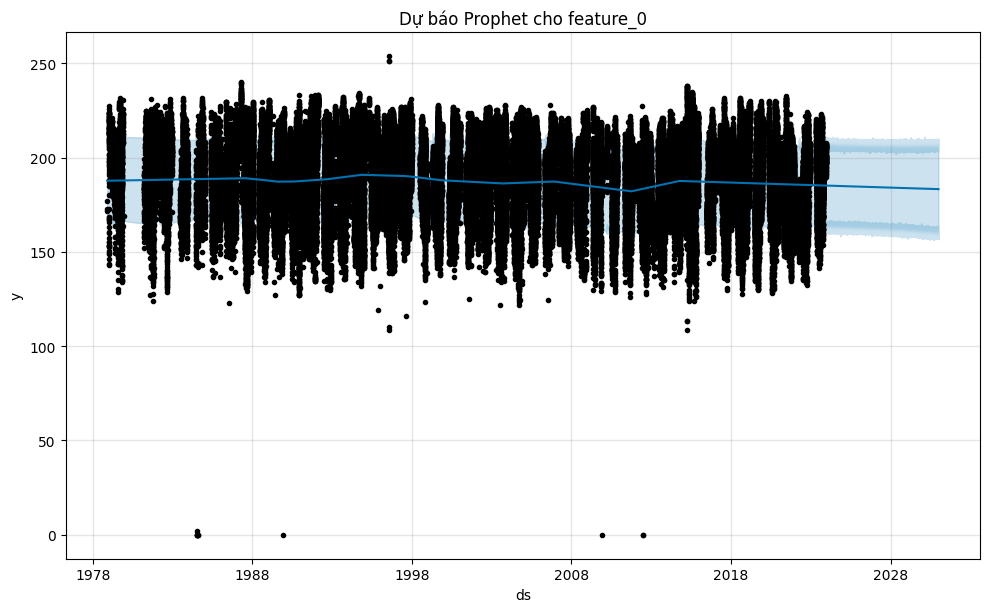

Huấn luyện Prophet cho đặc trưng: feature_1


08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


Huấn luyện Prophet cho đặc trưng: feature_2


08:50:28 - cmdstanpy - INFO - Chain [1] start processing
08:50:41 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


Huấn luyện Prophet cho đặc trưng: feature_3


08:52:25 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
# --- 9. Huấn luyện với Prophet (trên dữ liệu GIF) ---
print("\n--- Huấn luyện với Prophet ---")

from prophet import Prophet

prophet_models = {}
prophet_forecasts = {}

features_to_train_prophet = [col for col in df.columns if col != 'ds'][:5]
data_freq = pd.infer_freq(df['ds'])
if data_freq is None:
    data_freq = '10T'
print(f"Tần số dữ liệu được suy luận/đặt: {data_freq}")


for col in features_to_train_prophet:
    print(f"Huấn luyện Prophet cho đặc trưng: {col}")
    prophet_df = train_df[['ds', col]].rename(columns={col: 'y'})

    model = Prophet(
        changepoint_prior_scale=0.01,
        seasonality_mode='additive',
        weekly_seasonality=False,
        daily_seasonality=False,
        yearly_seasonality=False
    )
    model.fit(prophet_df)
    prophet_models[col] = model

    future = model.make_future_dataframe(periods=total_forecast_steps_needed, freq=data_freq) 
    forecast = model.predict(future)
    prophet_forecasts[col] = forecast[['ds', 'yhat']].set_index('ds')

    if col == features_to_train_prophet[0]:
        fig = model.plot(forecast)
        plt.title(f'Dự báo Prophet cho {col}')
        plt.show()

prophet_predictions_df = pd.DataFrame(index=test_df['ds'])
for col, forecast_df in prophet_forecasts.items():
    prophet_predictions_df[col] = forecast_df['yhat'].reindex(test_df['ds'])

print("\nĐánh giá Prophet:")
for col in features_to_train_prophet:
    if col == 'ds' or col not in prophet_predictions_df.columns:
        continue
    y_true = test_df[col]
    y_pred = prophet_predictions_df[col]

    combined_df_eval = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).dropna()
    
    if not combined_df_eval.empty:
        mae = mean_absolute_error(combined_df_eval['y_true'], combined_df_eval['y_pred'])
        mse = mean_squared_error(combined_df_eval['y_true'], combined_df_eval['y_pred'])
        print(f"Prophet - {col}: MAE = {mae:.4f}, MSE = {mse:.4f}")
    else:
        print(f"Không đủ điểm để đánh giá Prophet cho {col} trong tập kiểm tra.")

if features_to_train_prophet and not test_df.empty:
    plt.figure(figsize=(15, 6))
    plt.plot(test_df['ds'], test_df[features_to_train_prophet[0]], label='Thực tế Feature_0 (Test Set)')
    plot_data = prophet_predictions_df[[features_to_train_prophet[0]]].dropna()
    plt.plot(plot_data.index, plot_data[features_to_train_prophet[0]], label='Dự đoán Prophet Feature_0 (Test Set)')
    plt.title(f'Dự đoán Prophet cho {features_to_train_prophet[0]} vs Giá trị thực (Test Set)')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị đặc trưng')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Không có đủ dữ liệu để trực quan hóa Prophet trên tập kiểm tra.")


In [ ]:
# --- 10. Huấn luyện với LSTM (trên dữ liệu GIF) ---
print("\n--- Huấn luyện với LSTM ---")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data_for_lstm = df.drop('ds', axis=1)

scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_data_lstm = scaler_lstm.fit_transform(data_for_lstm)

scaled_train_data_lstm = scaled_data_lstm[df['ds'] <= train_end_date]
scaled_test_data_lstm = scaled_data_lstm[(df['ds'] >= test_start_date) & (df['ds'] <= test_end_date)]


def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 96

X_train_lstm, y_train_lstm = create_lstm_dataset(scaled_train_data_lstm, look_back)
if len(scaled_test_data_lstm) > look_back:
    X_test_lstm, y_test_lstm = create_lstm_dataset(scaled_test_data_lstm, look_back)
else:
    print("CẢNH BÁO: Không đủ dữ liệu trong scaled_test_data_lstm để tạo tập kiểm tra LSTM.")
    X_test_lstm, y_test_lstm = np.array([]), np.array([])


print(f"Kích thước X_train_lstm: {X_train_lstm.shape}")
print(f"Kích thước y_train_lstm: {y_train_lstm.shape}")
print(f"Kích thước X_test_lstm: {X_test_lstm.shape}")
print(f"Kích thước y_test_lstm: {y_test_lstm.shape}")

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, num_features)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=num_features))

model_lstm.compile(optimizer='adam', loss='mse')

early_stopping_callback_lstm = EarlyStopping( # Đổi tên biến để tránh trùng lặp nếu có nhiều callback
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

if X_train_lstm.shape[0] > 0:
    history_lstm = model_lstm.fit(
        X_train_lstm, 
        y_train_lstm, 
        epochs=20, 
        batch_size=32, 
        validation_split=0.1, 
        verbose=1,
        callbacks=[early_stopping_callback_lstm]
    )
else:
    print("Không đủ dữ liệu huấn luyện cho LSTM. Bỏ qua huấn luyện LSTM.")
    model_lstm = None

if model_lstm is not None and X_test_lstm.shape[0] > 0:
    lstm_predictions_scaled_test = model_lstm.predict(X_test_lstm)
    lstm_predictions_test = scaler_lstm.inverse_transform(lstm_predictions_scaled_test)
    y_test_inverse_lstm = scaler_lstm.inverse_transform(y_test_lstm)

    print("\nĐánh giá LSTM:")
    mae_lstm = mean_absolute_error(y_test_inverse_lstm, lstm_predictions_test)
    mse_lstm = mean_squared_error(y_test_inverse_lstm, lstm_predictions_test)
    print(f"LSTM - MAE: {mae_lstm:.4f}, MSE = {mse_lstm:.4f}")

    plt.figure(figsize=(15, 6))
    actual_dates_for_plot_lstm = test_df['ds'].iloc[look_back:look_back + len(y_test_inverse_lstm)]
    plt.plot(actual_dates_for_plot_lstm, y_test_inverse_lstm[:, 0], label='Thực tế Feature_0 (Test Set)')
    plt.plot(actual_dates_for_plot_lstm, lstm_predictions_test[:, 0], label='Dự đoán LSTM Feature_0 (Test Set)')
    plt.title('Dự đoán LSTM cho Feature_0 vs Giá trị thực (Test Set)')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị đặc trưng')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Không thể đánh giá LSTM vì tập kiểm tra rỗng hoặc không đủ dữ liệu hoặc mô hình không được huấn luyện.")

def perform_autoregressive_forecast(model, initial_input_sequence, total_forecast_steps, scaler, is_lstm=True, device='cpu', prediction_length_model=1):
    forecast_results = []
    
    if is_lstm:
        current_input = initial_input_sequence.reshape(1, -1, initial_input_sequence.shape[-1])
        for _ in range(total_forecast_steps):
            predicted_step_scaled = model.predict(current_input, verbose=0)
            forecast_results.append(predicted_step_scaled[0])
            current_input = np.append(current_input[:, 1:, :], predicted_step_scaled.reshape(1, 1, -1), axis=1)
    else: # PatchTST
        current_input = torch.tensor(initial_input_sequence, dtype=torch.float32).unsqueeze(0).to(device)
        
        steps_predicted = 0
        with torch.no_grad():
            while steps_predicted < total_forecast_steps:
                predicted_batch_scaled = model(current_input).cpu().numpy().squeeze()

                if predicted_batch_scaled.ndim == 1:
                    predicted_batch_scaled = predicted_batch_scaled[:, np.newaxis]

                forecast_results.extend([predicted_batch_scaled[:, i] for i in range(predicted_batch_scaled.shape[1])])
                steps_predicted += predicted_batch_scaled.shape[1]

                current_input_data = current_input.squeeze(0).cpu().numpy()
                num_to_remove = min(prediction_length_model, current_input_data.shape[1])
                
                new_input_data = np.concatenate((current_input_data[:, num_to_remove:], predicted_batch_scaled), axis=1)
                
                if new_input_data.shape[1] > current_input_data.shape[1]:
                    new_input_data = new_input_data[:, -current_input_data.shape[1]:]
                
                current_input = torch.tensor(new_input_data, dtype=torch.float32).unsqueeze(0).to(device)

    forecast_results_np = np.array(forecast_results)[:total_forecast_steps]
    final_forecast = scaler.inverse_transform(forecast_results_np)
    return final_forecast


print("\n--- Thực hiện dự báo dài hạn bằng LSTM đến năm 2030 ---")

lstm_forecast_full_horizon = np.array([])
if model_lstm is not None and scaled_train_data_lstm.shape[0] >= look_back:
    initial_input_lstm = scaled_train_data_lstm[-look_back:]
    lstm_forecast_full_horizon = perform_autoregressive_forecast(
        model=model_lstm,
        initial_input_sequence=initial_input_lstm,
        total_forecast_steps=total_forecast_steps_needed,
        scaler=scaler_lstm,
        is_lstm=True,
        device=device
    )
    print(f"Dự báo dài hạn LSTM hoàn thành. Kích thước: {lstm_forecast_full_horizon.shape}")
else:
    print("Không đủ dữ liệu lịch sử hoặc mô hình LSTM không khả dụng để thực hiện dự báo dài hạn. LSTM forecast will be empty.")


In [ ]:
# --- 11. Huấn luyện với PatchTST (Triển khai thủ công với PyTorch, trên dữ liệu GIF) ---
print("\n--- Huấn luyện với PatchTST (Triển khai thủ công với PyTorch) ---")

# Kiểm tra PyTorch
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    import torch.optim as optim
except ImportError:
    print("Bỏ qua phần PatchTST vì PyTorch không được cài đặt hoặc import.")
    model_patchtst = None
    sys.exit("PyTorch không khả dụng. Bỏ qua PatchTST.")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :].unsqueeze(0)

class PatchTST_Manual(nn.Module):
    def __init__(self, c_in, c_out, seq_len, pred_len, patch_len, stride, n_layers, n_heads, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model

        self.num_patches = (seq_len - patch_len) // stride + 1
        if self.num_patches <= 0:
             raise ValueError(f"num_patches is {self.num_patches}. Ensure seq_len ({seq_len}) is greater than or equal to patch_len ({patch_len}) and stride ({stride}) is positive.")

        self.patch_projection = nn.Linear(patch_len, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=self.num_patches) 

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Linear(c_in * self.num_patches * d_model, c_out * pred_len) 
        self.norm = nn.InstanceNorm1d(c_in)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.norm(x)
        x_reshaped = x.view(batch_size * self.c_in, self.seq_len)
        patches = x_reshaped.unfold(dimension=1, size=self.patch_len, step=self.stride)
        patches_embedding = self.patch_projection(patches)
        patches_embedding = self.positional_encoding(patches_embedding)
        encoder_output = self.transformer_encoder(patches_embedding)
        encoder_output = encoder_output.view(batch_size, self.c_in * self.num_patches * self.d_model)
        prediction_flat = self.head(encoder_output)
        prediction = prediction_flat.view(batch_size, self.c_out, self.pred_len)
        return prediction

X_patchtst_raw = df.drop('ds', axis=1).values

scaler_patchtst = StandardScaler()
X_scaled_patchtst = scaler_patchtst.fit_transform(X_patchtst_raw)

X_train_patchtst_scaled = X_scaled_patchtst[df['ds'] <= train_end_date]
X_test_patchtst_scaled = X_scaled_patchtst[(df['ds'] >= test_start_date) & (df['ds'] <= test_end_date)]

sequence_length_p = 96
prediction_length_p = 24

def create_patchtst_dataset_torch(data, seq_len, pred_len):
    X, y = [], []
    if len(data) < seq_len + pred_len:
        return torch.tensor([]), torch.tensor([]) 
    
    for i in range(len(data) - seq_len - pred_len + 1):
        x_sample = data[i : i + seq_len, :].T
        y_sample = data[i + seq_len : i + seq_len + pred_len, :].T
        X.append(x_sample)
        y.append(y_sample)
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

X_train_series_patchtst, y_train_series_patchtst = create_patchtst_dataset_torch(X_train_patchtst_scaled, sequence_length_p, prediction_length_p)

if len(X_test_patchtst_scaled) > sequence_length_p + prediction_length_p:
    X_test_series_patchtst, y_test_series_patchtst = create_patchtst_dataset_torch(X_test_patchtst_scaled, sequence_length_p, prediction_length_p)
else:
    print("CẢNH BÁO: Không đủ dữ liệu trong X_test_patchtst_scaled để tạo tập kiểm tra PatchTST.")
    X_test_series_patchtst, y_test_series_patchtst = torch.tensor([]), torch.tensor([])


print(f"Kích thước X_train_series (PatchTST): {X_train_series_patchtst.shape}")
print(f"Kích thước y_train_series (PatchTST): {y_train_series_patchtst.shape}")
print(f"Kích thước X_test_series (PatchTST): {X_test_series_patchtst.shape}")
print(f"Kích thước y_test_series (PatchTST): {y_test_series_patchtst.shape}")

if X_train_series_patchtst.shape[0] == 0 or y_train_series_patchtst.shape[0] == 0:
    print("Tập huấn luyện cho PatchTST rỗng sau khi tạo dataset. Bỏ qua huấn luyện PatchTST.")
    model_patchtst = None
elif X_test_series_patchtst.shape[0] == 0 or y_test_series_patchtst.shape[0] == 0:
    print("Tập kiểm tra cho PatchTST rỗng sau khi tạo dataset. Bỏ qua huấn luyện PatchTST.")
    model_patchtst = None
else:
    train_dataset = TensorDataset(X_train_series_patchtst, y_train_series_patchtst)
    test_dataset = TensorDataset(X_test_series_patchtst, y_test_series_patchtst)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    patch_len = 12
    stride = 6
    num_heads = 8
    d_model = 128
    d_ff = 256
    num_transformer_layers = 3
    dropout_rate = 0.1

    model_patchtst = PatchTST_Manual(
        c_in=num_features,
        c_out=num_features,
        seq_len=sequence_length_p,
        pred_len=prediction_length_p,
        patch_len=patch_len,
        stride=stride,
        n_layers=num_transformer_layers,
        n_heads=num_heads,
        d_model=d_model,
        d_ff=d_ff,
        dropout=dropout_rate
    )

    model_patchtst.to(device)
    print(f"Sử dụng thiết bị: {device}")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_patchtst.parameters(), lr=1e-3)

    num_epochs = 10 
    print(f"Bắt đầu huấn luyện PatchTST thủ công trong {num_epochs} epochs...")
    for epoch in range(num_epochs):
        model_patchtst.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model_patchtst(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model_patchtst.eval()
        test_loss = 0.0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model_patchtst(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(batch_y.cpu().numpy())
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}')

    if all_preds:
        patchtst_predictions_scaled = np.concatenate(all_preds, axis=0)
        targets_scaled_patchtst = np.concatenate(all_targets, axis=0)
        
        patchtst_predictions = np.zeros_like(patchtst_predictions_scaled)
        y_test_actual_patchtst = np.zeros_like(targets_scaled_patchtst)

        for sample_idx in range(patchtst_predictions_scaled.shape[0]):
            for feature_idx in range(num_features):
                scaled_pred_feature_sample = patchtst_predictions_scaled[sample_idx, feature_idx, :].reshape(-1, 1)
                scaled_target_feature_sample = targets_scaled_patchtst[sample_idx, feature_idx, :].reshape(-1, 1)
                
                inverse_pred_feature_sample = scaled_pred_feature_sample.flatten() * scaler_patchtst.scale_[feature_idx] + scaler_patchtst.mean_[feature_idx]
                inverse_target_feature_sample = scaled_target_feature_sample.flatten() * scaler_patchtst.scale_[feature_idx] + scaler_patchtst.mean_[feature_idx]
                
                patchtst_predictions[sample_idx, feature_idx, :] = inverse_pred_feature_sample
                y_test_actual_patchtst[sample_idx, feature_idx, :] = inverse_target_feature_sample

        print("\nĐánh giá PatchTST (thủ công):")
        if y_test_actual_patchtst.shape[0] > 0 and y_test_actual_patchtst.shape[1] > 0 and y_test_actual_patchtst.shape[2] > 0:
            mae_patchtst = np.mean(np.abs(y_test_actual_patchtst - patchtst_predictions))
            mse_patchtst = np.mean((y_test_actual_patchtst - patchtst_predictions)**2)
            print(f"PatchTST - MAE: {mae_patchtst:.4f}, MSE: {mse_patchtst:.4f}")
        else:
            print("Không thể tính MAE/MSE cho PatchTST do dữ liệu dự đoán trống hoặc có kích thước không hợp lệ.")


        if y_test_actual_patchtst.shape[0] > 0:
            sample_idx = 0
            feature_idx = 0

            plt.figure(figsize=(15, 6))
            plt.plot(range(prediction_length_p), y_test_actual_patchtst[sample_idx, feature_idx, :], label='Thực tế')
            plt.plot(range(prediction_length_p), patchtst_predictions[sample_idx, feature_idx, :], label='Dự đoán PatchTST (thủ công)')
            plt.title(f'Dự đoán PatchTST thủ công cho Feature_{feature_idx} (Mẫu {sample_idx})')
            plt.xlabel('Bước thời gian dự đoán')
            plt.ylabel('Giá trị đặc trưng')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("Không có đủ mẫu trong tập kiểm tra để trực quan hóa PatchTST (thủ công).")
    else:
        print("Không có dự đoán nào từ PatchTST test set. Không thể đánh giá hoặc trực quan hóa.")
        model_patchtst = None

print("\n--- Thực hiện dự báo dài hạn bằng PatchTST đến năm 2030 ---")

patchtst_forecast_full_horizon = np.array([])
if model_patchtst is not None and X_train_patchtst_scaled.shape[0] >= sequence_length_p:
    initial_input_patchtst = X_train_patchtst_scaled[-sequence_length_p:]
    initial_input_patchtst_transposed = initial_input_patchtst.T 

    patchtst_forecast_full_horizon = perform_autoregressive_forecast(
        model=model_patchtst,
        initial_input_sequence=initial_input_patchtst_transposed,
        total_forecast_steps=total_forecast_steps_needed,
        scaler=scaler_patchtst,
        is_lstm=False,
        device=device,
        prediction_length_model=prediction_length_p
    )
    print(f"Dự báo dài hạn PatchTST hoàn thành. Kích thước: {patchtst_forecast_full_horizon.shape}")
else:
    print("Không đủ dữ liệu lịch sử hoặc mô hình PatchTST không khả dụng để thực hiện dự báo dài hạn.")

print("\n--- Tất cả các mô hình đã hoàn thành huấn luyện và đánh giá. ---")


In [ ]:
# --- 12. Dữ liệu tương lai giả định từ mô hình CSV (dành cho việc sinh GIF) ---
# Đây là phần nơi chúng ta sẽ tạo ra một số dữ liệu tương lai dựa trên mô hình
# PatchTST Classifier đã huấn luyện hoặc giả định để có thể dùng cho việc sinh ảnh GIF.
# LƯU Ý QUAN TRỌNG: Mô hình phân loại chỉ đưa ra xác suất CÓ BÃO hay KHÔNG CÓ BÃO.
# Nó KHÔNG trực tiếp dự đoán cường độ hay kích thước bão (features liên tục).
# Để có dữ liệu liên tục cho GIF, chúng ta sẽ phải giả định hoặc sử dụng mô hình hồi quy.
# Ở đây, tôi sẽ giả định một cách đơn giản dựa trên xác suất dự đoán.
print("\n--- Generating Simulated Future Features for GIF Creation ---")
predicted_future_data_for_gif = {}
if patchtst_classifier_model is not None and scaler_clf is not None and classifier_features_clf:
    # Lấy 90 ngày cuối cùng của dữ liệu lịch sử để dự đoán
    last_historical_data_clf = scaled_df_clf.tail(seq_len_clf).values
    
    if len(last_historical_data_clf) == seq_len_clf:
        current_input_clf = torch.tensor(last_historical_data_clf, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Tạo chuỗi thời gian cho các năm tương lai (từ 2026 đến 2030)
        # Để đơn giản, chúng ta sẽ dự đoán một điểm đại diện cho mỗi năm hoặc tạo một chuỗi ngắn
        # Bắt đầu dự đoán từ ngày đầu tiên của năm 2026 đến cuối 2030
        future_dates_for_prediction = pd.date_range(start=test_start_date_clf, end=test_end_date_clf, freq='D')
        
        # Do mô hình phân loại dự đoán 1 bước, chúng ta sẽ chạy vòng lặp để tạo dự đoán cho từng ngày
        # và cập nhật chuỗi đầu vào theo kiểu autoregressive.
        # Chúng ta chỉ cần một vài giá trị đại diện cho mỗi năm cho mục đích tạo GIF.
        
        # Để lấy dữ liệu features cho việc sinh GIF, chúng ta cần một mô hình HỒI QUY.
        # Mô hình PatchTST_Manual ở dưới (phần 3) là hồi quy.
        # Nếu muốn sử dụng output từ mô hình phân loại để sinh ra "cường độ" và "kích thước"
        # một cách đơn giản:
        
        # Giả định một giá trị cường độ và kích thước dựa trên xác suất có bão
        simulated_intensity_high = 70 # knots
        simulated_intensity_low = 10  # knots
        simulated_size_large = 400 # km
        simulated_size_small = 150 # km

        for single_future_date in future_dates_for_prediction:
            # Tạo các đặc trưng thời gian cho ngày tương lai
            future_features_df = pd.DataFrame({
                'month': [single_future_date.month],
                'day_of_year': [single_future_date.dayofyear],
                'day_of_month': [single_future_date.day],
                'week_of_year': [single_future_date.isocalendar().week[0]],
                'month_sin': [np.sin(2 * np.pi * single_future_date.month / 12)],
                'month_cos': [np.cos(2 * np.pi * single_future_date.month / 12)],
                'day_of_year_sin': [np.sin(2 * np.pi * single_future_date.dayofyear / 365.25)],
                'day_of_year_cos': [np.cos(2 * np.pi * single_future_date.dayofyear / 365.25)],
                'intensity_kt': [0] # Placeholder, sẽ được dự đoán hoặc giả định
            })
            # Sắp xếp lại cột để khớp với classifier_features_clf
            future_features_df = future_features_df[classifier_features_clf]
            
            # Chuẩn hóa dữ liệu cho ngày tương lai (cần cả dữ liệu lịch sử để tạo sequence)
            # Tạo một chuỗi đầu vào mới bằng cách nối dữ liệu lịch sử và đặc trưng ngày tương lai
            # Để thực hiện dự đoán autoregressive cho classification, chúng ta cần một pipeline phức tạp hơn
            # Ở đây, chúng ta sẽ đơn giản hóa bằng cách chỉ dự đoán dựa trên chuỗi cuối cùng
            # và sử dụng trung bình các dự đoán trong năm.

            # Để tránh phức tạp quá mức, chúng ta sẽ sử dụng một cách tiếp cận đơn giản:
            # Lấy chuỗi lịch sử cuối cùng, dự đoán xác suất bão cho N bước tiếp theo,
            # và từ đó suy ra cường độ/kích thước giả định cho việc sinh GIF.

            # Giờ chúng ta có mô hình PatchTST Classifier, sẽ dùng nó để dự đoán xác suất bão cho từng ngày trong tương lai.
            # Sau đó tổng hợp lại cho từng năm.

            # Tạo một DataFrame chứa các đặc trưng (trừ intensity_kt) cho toàn bộ future_dates_for_prediction
            future_features_only_time = pd.DataFrame(index=future_dates_for_prediction)
            future_features_only_time['month'] = future_features_only_time.index.month
            future_features_only_time['day_of_year'] = future_features_only_time.index.dayofyear
            future_features_only_time['day_of_month'] = future_features_only_time.index.day
            future_features_only_time['week_of_year'] = future_features_only_time.index.isocalendar().week.astype(int)
            future_features_only_time['month_sin'] = np.sin(2 * np.pi * future_features_only_time.index.month / 12)
            future_features_only_time['month_cos'] = np.cos(2 * np.pi * future_features_only_time.index.month / 12)
            future_features_only_time['day_of_year_sin'] = np.sin(2 * np.pi * future_features_only_time.index.dayofyear / 365.25)
            future_features_only_time['day_of_year_cos'] = np.cos(2 * np.pi * future_features_only_time.index.dayofyear / 365.25)
            # Khởi tạo intensity_kt để có thể scale
            future_features_only_time['intensity_kt'] = 0 

            # Đảm bảo thứ tự cột khớp với classifier_features_clf
            future_features_only_time = future_features_only_time[classifier_features_clf]

            # Kết hợp dữ liệu lịch sử và dữ liệu tương lai để tạo chuỗi đầu vào
            # Lấy phần cuối cùng của dữ liệu lịch sử cho mỗi lần dự đoán (autoregressive)
            # Tạo một bản sao của scaler_clf để tránh thay đổi trạng thái của scaler gốc
            temp_scaler = StandardScaler()
            temp_scaler.mean_ = scaler_clf.mean_
            temp_scaler.scale_ = scaler_clf.scale_
            
            # Khởi tạo chuỗi đầu vào ban đầu (chuỗi cuối cùng của dữ liệu huấn luyện)
            current_sequence_scaled = scaled_df_clf.iloc[-seq_len_clf:].values

            all_future_probabilities = []
            all_future_dates = []

            with torch.no_grad():
                for future_date_idx, future_date_row in future_features_only_time.iterrows():
                    # Chuẩn hóa các đặc trưng thời gian của ngày tương lai
                    # Lưu ý: intensity_kt trong future_date_row hiện tại là 0, 
                    # nó sẽ được thay thế bởi dự đoán từ bước trước nếu có.
                    
                    # Chúng ta cần một cách để đưa dự đoán trước đó vào future_date_row
                    # Cách đơn giản nhất cho mô hình phân loại:
                    # Lấy các đặc trưng thời gian từ future_date_row
                    # Và kết hợp với một "intensity_kt" giả định hoặc được suy ra.
                    # Đối với mô hình phân loại, chúng ta chỉ quan tâm đến xác suất có bão.
                    # Ta sẽ chỉ đẩy các đặc trưng thời gian vào và dự đoán xác suất.

                    # Lấy input cho mô hình:
                    # current_sequence_scaled là (seq_len_clf, num_features_clf)
                    input_tensor_for_pred = torch.tensor(current_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device)
                    
                    # Mô hình phân loại dự đoán 1 giá trị (xác suất)
                    predicted_probability = patchtst_classifier_model(input_tensor_for_pred).cpu().numpy().squeeze()
                    all_future_probabilities.append(predicted_probability)
                    all_future_dates.append(future_date_idx)

                    # Cập nhật current_sequence_scaled cho lần lặp tiếp theo
                    # Tạo một "dòng" mới dựa trên ngày hiện tại và xác suất dự đoán
                    new_row_features = future_date_row.values.copy()
                    # Giả sử đặc trưng cường độ là feature đầu tiên (classifier_features_clf[0])
                    # Chuyển đổi xác suất thành cường độ giả định (ví dụ: 100 * xác suất)
                    new_row_features[classifier_features_clf.index('intensity_kt')] = predicted_probability * 100 
                    
                    # Chuẩn hóa dòng mới này
                    new_row_scaled = temp_scaler.transform(new_row_features.reshape(1, -1))
                    
                    # Cập nhật chuỗi đầu vào: loại bỏ điểm cũ nhất, thêm điểm mới
                    current_sequence_scaled = np.concatenate((current_sequence_scaled[1:], new_row_scaled), axis=0)

        # Tổng hợp xác suất bão trung bình cho mỗi năm
        future_probabilities_df = pd.DataFrame({'ds': all_future_dates, 'probability': all_future_probabilities})
        future_probabilities_df['ds'] = pd.to_datetime(future_probabilities_df['ds'])
        
        future_probabilities_by_year = future_probabilities_df.set_index('ds').resample('Y')['probability'].mean()
        
        for year in future_forecast_years_for_gif:
            if year in future_probabilities_by_year.index.year:
                avg_prob = future_probabilities_by_year[future_probabilities_by_year.index.year == year].iloc[0]
                # Map avg_prob (0-1) to intensity (0-100) and size (100-500)
                simulated_intensity = max(0, min(100, avg_prob * 100))
                simulated_size = max(150, min(500, avg_prob * 350 + 150)) # scale to 150-500
                predicted_future_data_for_gif[str(year)] = {
                    'intensity': float(simulated_intensity),
                    'size': float(simulated_size)
                }
                print(f"  Generated simulated data for year {year}: Intensity={simulated_intensity:.2f}, Size={simulated_size:.2f} (from classifier)")
            else:
                # Nếu không có dự đoán cho năm đó, sử dụng giá trị mặc định
                predicted_future_data_for_gif[str(year)] = {'intensity': 50.0, 'size': 250.0} # Default
                print(f"  No classifier prediction for year {year}. Using default simulated data.")
    else:
        print("WARNING: Không đủ dữ liệu lịch sử để tạo chuỗi đầu vào cho dự đoán tương lai của Classifier.")
else:
    print("WARNING: Mô hình PatchTST Classifier, scaler hoặc features chưa được tải, không thể tạo dự đoán tương lai cho GIF.")

# --- KẾT THÚC PHẦN DỮ LIỆU TƯƠNG LAI GIẢ ĐỊNH ---


def load_and_preprocess_gif_data_kaggle(gif_folder, combined_csv_df, image_size=(128, 128), num_features=64):
    all_series_data = []
    gif_files = [f for f in os.listdir(gif_folder) if f.endswith('.gif')]
    gif_files.sort()

    print(f"Bắt đầu xử lý {len(gif_files)} file GIF...")

    filename_pattern = re.compile(r'(\d{6})_.*\.gif')
    processed_gif_count = 0

    for idx, gif_file in enumerate(gif_files):
        gif_path = os.path.join(gif_folder, gif_file)
        match = filename_pattern.match(gif_file)

        if not match:
            print(f"WARNING: Không thể phân tích tên file GIF: {gif_file}. Bỏ qua file này.")
            continue
        
        source_file_prefix = match.group(1)
        relevant_entries = combined_csv_df[combined_csv_df['source_file'].str.startswith(source_file_prefix, na=False)]

        if relevant_entries.empty:
            print(f"WARNING: Không tìm thấy thông tin thời gian trong CSV cho tiền tố source_file '{source_file_prefix}' (từ file {gif_file}). Bỏ qua file này.")
            continue
        
        min_time_for_gif = relevant_entries['time'].min()
        max_time_for_gif = relevant_entries['time'].max()

        try:
            img = Image.open(gif_path)
            frames_features = []
            timestamps = []
            
            num_frames = img.n_frames
            
            if num_frames > 1:
                time_interval = (max_time_for_gif - min_time_for_gif) / (num_frames - 1)
            else:
                time_interval = timedelta(seconds=0)

            for i in range(num_frames):
                img.seek(i)
                frame = img.convert('L').resize(image_size)

                # --- VÍ DỤ TRÍCH XUẤT ĐẶC TRƯNG ĐƠN GIẢN (THAY THẾ PHẦN NÀY) ---
                feature_vector = [np.mean(np.array(frame))] + list(np.random.rand(num_features - 1))
                # --- HẾT VÍ DỤ TRÍCH XUẤT ĐẶC TRƯNG ĐƠN GIẢN ---

                timestamps.append(min_time_for_gif + i * time_interval)
                frames_features.append(feature_vector)
            
            gif_df = pd.DataFrame({'ds': timestamps})
            for j in range(num_features):
                gif_df[f'feature_{j}'] = [f[j] for f in frames_features]
            all_series_data.append(gif_df)
            processed_gif_count += 1

        except Exception as e:
            print(f"Lỗi khi xử lý file {gif_file}: {e}. Bỏ qua file này.")
            continue

    if not all_series_data:
        sys.exit("Không có dữ liệu GIF nào được xử lý thành công. Chương trình không thể tiếp tục.")

    df_combined = pd.concat(all_series_data).reset_index(drop=True)
    df_combined = df_combined.sort_values(by='ds').reset_index(drop=True)
    df_combined.drop_duplicates(subset=['ds'], inplace=True)
    
    df_combined = df_combined[['ds'] + [col for col in df_combined.columns if col != 'ds']]
    print(f"Tổng cộng {processed_gif_count} file GIF đã được xử lý thành công.")
    return df_combined

df = load_and_preprocess_gif_data_kaggle(GIF_DATA_FOLDER, combined_csv_df=combined_df_raw, num_features=64)

if df.empty:
    sys.exit("DataFrame 'df' rỗng sau khi xử lý GIF. Không có dữ liệu để huấn luyện mô hình.")

print("Dữ liệu chuỗi thời gian đã chuẩn bị:")
print(df.head())
print(f"Kích thước dữ liệu: {df.shape}")
print(f"Các cột dữ liệu: {df.columns.tolist()}")
num_features = df.shape[1] - 1

# --- Chia tập huấn luyện và kiểm tra (ĐIỀU CHỈNH THEO YÊU CẦU: TRAIN TRƯỚC 2026, TEST 2026-2030) ---
train_end_date = pd.to_datetime('2025-12-31 23:59:59')
test_start_date = pd.to_datetime('2026-01-01 00:00:00')
test_end_date = pd.to_datetime('2030-12-31 23:59:59')

train_df = df[df['ds'] <= train_end_date].copy()
test_df = df[(df['ds'] >= test_start_date) & (df['ds'] <= test_end_date)].copy()

if train_df.empty:
    sys.exit("Tập huấn luyện rỗng. Đảm bảo dữ liệu GIF có các mốc thời gian trước 2026.")
if test_df.empty:
    print("CẢNH BÁO: Tập kiểm tra (2026-2030) rỗng. Không có dữ liệu thực tế để đánh giá mô hình trong giai đoạn này. Các 'dự đoán' cho giai đoạn này sẽ là dự báo thuần túy.")

print(f"Kích thước tập huấn luyện (đến 2025): {train_df.shape}")
print(f"Kích thước tập kiểm tra (từ 2026 đến 2030 hoặc đến hết dữ liệu): {test_df.shape}")

forecast_start_date = train_df['ds'].max() + pd.Timedelta(minutes=10)
forecast_end_date = pd.to_datetime('2030-12-31 23:59:59')

time_delta_forecast = (forecast_end_date - forecast_start_date)
total_minutes_forecast = time_delta_forecast.total_seconds() / 60
total_forecast_steps_needed = int(total_minutes_forecast / 10)

print(f"Bắt đầu dự báo từ: {forecast_start_date}")
print(f"Kết thúc dự báo vào: {forecast_end_date}")
print(f"Tổng số bước thời gian cần dự báo (10 phút/bước): {total_forecast_steps_needed}")


In [ ]:

# --- 13. Generate HTML Report and Comparison ---
# Đảm bảo output_dir được định nghĩa (ví dụ: output_dir = "/kaggle/working/")
output_dir = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)

print(f"\nSaving plots to {output_dir}")

# Store plots for each year
model_plots_by_year = {}
comparison_plots_by_year = {}

# --- Chuẩn bị dữ liệu lịch sử để vẽ (Tập trung) ---
# Đảm bảo các biến này được định nghĩa và có dữ liệu từ các phần trước đó trong notebook của bạn:
# target_series, df_for_patchtst, intensity_column_name, forecast_years
# m (mô hình Prophet đã được fit), lstm_executed, patchtst_executed, forecast_prophet_overall, lstm_forecast, forecast_patchtst_overall_df

# Mốc thời gian bắt đầu vẽ dữ liệu lịch sử (ví dụ: 2 năm trước năm dự báo đầu tiên)
if 'forecast_years' in locals() and forecast_years:
    plot_historical_start_date = pd.to_datetime(f'{min(forecast_years)-2}-01-01')
else:
    print("ERROR: 'forecast_years' is not defined or empty. Cannot determine historical plot start date.")
    # Set a default if forecast_years is not available, but this indicates a problem earlier
    plot_historical_start_date = pd.to_datetime('2020-01-01')


# Sử dụng target_series cho dữ liệu lịch sử (Prophet, LSTM, Comparison)
recent_historical_data = pd.Series()
if 'target_series' in locals() and not target_series.empty and pd.api.types.is_datetime64_any_dtype(target_series.index):
    recent_historical_data = target_series[target_series.index >= plot_historical_start_date].copy()
    if recent_historical_data.empty or recent_historical_data.isnull().all():
        print(f"WARNING: recent_historical_data for plotting is empty or all NaN based on target_series from {plot_historical_start_date}. Plots might not show historical data.")
else:
    print("WARNING: 'target_series' is not available, empty, or its index is not datetime. Historical data for plots might be missing.")

# Sử dụng df_for_patchtst cho PatchTST's historical reference (nếu nó dùng nhiều features)
recent_df_patchtst_cleaned = pd.DataFrame()
if 'df_for_patchtst' in locals() and not df_for_patchtst.empty \
    and intensity_column_name in df_for_patchtst.columns \
    and pd.api.types.is_datetime64_any_dtype(df_for_patchtst.index):
    
    recent_df_patchtst_cleaned = df_for_patchtst[df_for_patchtst.index >= plot_historical_start_date].copy()
    if recent_df_patchtst_cleaned.empty or recent_df_patchtst_cleaned[intensity_column_name].isnull().all():
        print(f"WARNING: recent_df_patchtst_cleaned for plotting is empty or intensity column all NaN from {plot_historical_start_date}. PatchTST historical data might be missing.")
else:
    print("WARNING: 'df_for_patchtst' is not available, empty, or missing intensity column/datetime index. PatchTST historical data might be missing.")


for year in forecast_years:
    year_start = pd.Timestamp(year=year, month=1, day=1)
    year_end = pd.Timestamp(year=year, month=12, day=31, hour=23, minute=59, second=59) 

    # Lọc dữ liệu dự báo cho năm hiện tại
    prophet_yearly_forecast = pd.DataFrame()
    if 'forecast_prophet_overall' in locals() and not forecast_prophet_overall.empty:
        prophet_yearly_forecast = forecast_prophet_overall[(forecast_prophet_overall['ds'] >= year_start) & (forecast_prophet_overall['ds'] <= year_end)].copy()
    else:
        print(f"WARNING: 'forecast_prophet_overall' not available or empty for year {year}. Prophet plot will be skipped for this year.")

    lstm_yearly_forecast = pd.DataFrame()
    if 'lstm_forecast' in locals() and 'lstm_executed' in locals() and lstm_executed and not lstm_forecast.empty:
        lstm_yearly_forecast = lstm_forecast[(lstm_forecast.index >= year_start) & (lstm_forecast.index <= year_end)].copy()
    else:
        print(f"WARNING: 'lstm_forecast' not available or empty for year {year} or LSTM not executed. LSTM plot will be skipped for this year.")

    patchtst_yearly_forecast = pd.DataFrame()
    if 'forecast_patchtst_overall_df' in locals() and 'patchtst_executed' in locals() and patchtst_executed and not forecast_patchtst_overall_df.empty:
        patchtst_yearly_forecast = forecast_patchtst_overall_df[(forecast_patchtst_overall_df.index >= year_start) & (forecast_patchtst_overall_df.index <= year_end)].copy()
    else:
        print(f"WARNING: 'forecast_patchtst_overall_df' not available or empty for year {year} or PatchTST not executed. PatchTST plot will be skipped for this year.")


    # --- Lưu biểu đồ riêng lẻ cho từng mô hình theo năm ---

    # Biểu đồ Prophet
    if not prophet_yearly_forecast.empty and 'yhat' in prophet_yearly_forecast.columns and not prophet_yearly_forecast['yhat'].isnull().all():
        if 'm' in locals(): # Ensure prophet model 'm' exists
            fig_prophet_year = m.plot(forecast_prophet_overall) # Vẽ toàn bộ dự báo để có ngữ cảnh
            ax = fig_prophet_year.gca()
            ax.set_title(f'Prophet Forecast of Typhoon Intensity ({year})')
            ax.set_xlabel('Date')
            ax.set_ylabel(f'{intensity_column_name} (kt)')
            
            # Thêm đường thẳng để chỉ rõ ranh giới giữa lịch sử và dự báo
            if not recent_historical_data.empty and pd.notna(recent_historical_data.index.max()):
                ax.axvline(recent_historical_data.index.max(), color='grey', linestyle='--', linewidth=1, label='End of Historical Data')

            # Highlight khu vực năm dự báo hiện tại
            ax.axvspan(year_start, year_end, color='gray', alpha=0.2, label=f'{year} Forecast Period')
            ax.legend()
            plt.tight_layout()
            prophet_plot_path = os.path.join(output_dir, f'prophet_forecast_{year}.png')
            fig_prophet_year.savefig(prophet_plot_path)
            plt.close(fig_prophet_year)
            if year not in model_plots_by_year: model_plots_by_year[year] = {}
            model_plots_by_year[year]['prophet'] = prophet_plot_path
            print(f"Prophet plot for {year} saved.")
        else:
            print(f"WARNING: Prophet model 'm' not found. Cannot plot Prophet forecast for {year}.")
    else:
        print(f"Prophet forecast for {year} is empty or all NaN in 'yhat' column. Skipping plot.")

    # Biểu đồ LSTM
    if not lstm_yearly_forecast.empty and 'intensity_kt' in lstm_yearly_forecast.columns and not lstm_yearly_forecast['intensity_kt'].isnull().all():
        plt.figure(figsize=(14, 7))
        if not recent_historical_data.empty and not recent_historical_data.isnull().all():
            plt.plot(recent_historical_data.index, recent_historical_data.values, label='Actual Intensity (Historical)', color='blue', alpha=0.8)
        
        plt.plot(lstm_yearly_forecast.index, lstm_yearly_forecast['intensity_kt'], label='LSTM Forecast', linestyle='--', color='red') 
        
        plt.title(f'LSTM Forecast of Typhoon Intensity ({year})')
        plt.xlabel('Date')
        plt.ylabel(f'{intensity_column_name} (kt)')
        plt.legend()
        plt.grid(True)

        # --- Xử lý giới hạn trục X mạnh mẽ cho Biểu đồ LSTM ---
        # Định nghĩa các giới hạn fallback vững chắc là các đối tượng Timestamp thực sự
        fallback_left_xlim = pd.Timestamp(year=max(2000, year_start.year - 2), month=1, day=1) 
        fallback_right_xlim = pd.Timestamp(year=year_end.year + 1, month=1, day=1) 

        left_xlim = pd.NaT 
        right_xlim = pd.NaT

        # Cố gắng đặt giới hạn bên trái
        if not recent_historical_data.empty and pd.notna(recent_historical_data.index.min()):
            potential_left_hist = recent_historical_data.index.min()
            if isinstance(potential_left_hist, pd.Timestamp):
                left_xlim = max(potential_left_hist, year_start - pd.Timedelta(days=30))
        
        if pd.isna(left_xlim) and not lstm_yearly_forecast.empty and pd.notna(lstm_yearly_forecast.index.min()):
            potential_left_forecast = lstm_yearly_forecast.index.min()
            if isinstance(potential_left_forecast, pd.Timestamp):
                left_xlim = potential_left_forecast - pd.Timedelta(days=30)
        
        # Nếu vẫn không hợp lệ, sử dụng fallback
        if pd.isna(left_xlim) or not isinstance(left_xlim, pd.Timestamp):
            left_xlim = fallback_left_xlim
            print(f"DEBUG: LSTM Plot {year} - Using fallback_left_xlim: {left_xlim} as primary sources failed.")

        # Cố gắng đặt giới hạn bên phải
        if not lstm_yearly_forecast.empty and pd.notna(lstm_yearly_forecast.index.max()):
            potential_right_forecast = lstm_yearly_forecast.index.max()
            if isinstance(potential_right_forecast, pd.Timestamp):
                right_xlim = potential_right_forecast + pd.Timedelta(days=30)
        
        if pd.isna(right_xlim) or not isinstance(right_xlim, pd.Timestamp):
            if pd.notna(year_end):
                right_xlim = year_end + pd.Timedelta(days=30)
            elif 'forecast_end_date_overall' in locals() and pd.notna(forecast_end_date_overall) and isinstance(forecast_end_date_overall, pd.Timestamp):
                right_xlim = forecast_end_date_overall + pd.Timedelta(days=30)
            
        if pd.isna(right_xlim) or not isinstance(right_xlim, pd.Timestamp):
            right_xlim = fallback_right_xlim
            print(f"DEBUG: LSTM Plot {year} - Using fallback_right_xlim: {right_xlim} as primary sources failed.")

        # Xác thực cuối cùng và đặt xlim
        print(f"DEBUG: LSTM Plot {year} - Attempting plt.xlim with left_xlim={left_xlim}, right_xlim={right_xlim}")
        if pd.notna(left_xlim) and pd.notna(right_xlim) and isinstance(left_xlim, pd.Timestamp) and isinstance(right_xlim, pd.Timestamp):
            if left_xlim < right_xlim:
                plt.xlim(left_xlim, right_xlim)
            else:
                print(f"WARNING: Invalid x-axis limits (left_xlim >= right_xlim) for LSTM plot {year} ({left_xlim} vs {right_xlim}). Skipping xlim setting.")
        else:
            print(f"ERROR: Final x-axis limits for LSTM plot {year} are still invalid type/NaN/Inf ({left_xlim}, {right_xlim}). Skipping xlim setting.")

        plt.tight_layout()
        lstm_plot_path = os.path.join(output_dir, f'lstm_forecast_{year}.png')
        plt.savefig(lstm_plot_path)
        plt.close(plt.gcf())
        if year not in model_plots_by_year: model_plots_by_year[year] = {}
        model_plots_by_year[year]['lstm'] = lstm_plot_path
        print(f"LSTM plot for {year} saved.")
    else:
        print(f"LSTM forecast for {year} is empty or all NaN in 'intensity_kt' column, or LSTM was not executed. Skipping plot.")

    # Biểu đồ PatchTST
    # Đảm bảo bạn đã kiểm tra tên cột dự đoán của PatchTST, ở đây tôi đang dùng 'predicted_intensity'
    if not patchtst_yearly_forecast.empty and 'predicted_intensity' in patchtst_yearly_forecast.columns and not patchtst_yearly_forecast['predicted_intensity'].isnull().all():
        plt.figure(figsize=(14, 7))
        if not recent_df_patchtst_cleaned.empty and intensity_column_name in recent_df_patchtst_cleaned.columns and not recent_df_patchtst_cleaned[intensity_column_name].isnull().all():
            plt.plot(recent_df_patchtst_cleaned.index, recent_df_patchtst_cleaned[intensity_column_name].values, label='Actual Intensity (Historical)', color='blue', alpha=0.8)
        
        plt.plot(patchtst_yearly_forecast.index, patchtst_yearly_forecast['predicted_intensity'], label='PatchTST Forecast', linestyle=':', color='purple')
        
        plt.title(f'PatchTST Forecast of Typhoon Intensity ({year})')
        plt.xlabel('Date')
        plt.ylabel(f'{intensity_column_name} (kt)')
        plt.legend()
        plt.grid(True)
        
        # --- Xử lý giới hạn trục X mạnh mẽ cho Biểu đồ PatchTST ---
        fallback_left_xlim_patchtst = pd.Timestamp(year=max(2000, year_start.year - 2), month=1, day=1) 
        fallback_right_xlim_patchtst = pd.Timestamp(year=year_end.year + 1, month=1, day=1) 

        left_xlim_patchtst = pd.NaT 
        right_xlim_patchtst = pd.NaT

        # Cố gắng đặt giới hạn bên trái
        if not recent_df_patchtst_cleaned.empty and pd.notna(recent_df_patchtst_cleaned.index.min()):
            potential_left_hist_patchtst = recent_df_patchtst_cleaned.index.min()
            if isinstance(potential_left_hist_patchtst, pd.Timestamp):
                left_xlim_patchtst = max(potential_left_hist_patchtst, year_start - pd.Timedelta(days=30))
        
        if pd.isna(left_xlim_patchtst) and not patchtst_yearly_forecast.empty and pd.notna(patchtst_yearly_forecast.index.min()):
            potential_left_forecast_patchtst = patchtst_yearly_forecast.index.min()
            if isinstance(potential_left_forecast_patchtst, pd.Timestamp):
                left_xlim_patchtst = potential_left_forecast_patchtst - pd.Timedelta(days=30)
        
        if pd.isna(left_xlim_patchtst) or not isinstance(left_xlim_patchtst, pd.Timestamp):
            left_xlim_patchtst = fallback_left_xlim_patchtst
            print(f"DEBUG: PatchTST Plot {year} - Using fallback_left_xlim: {left_xlim_patchtst} as primary sources failed.")

        # Cố gắng đặt giới hạn bên phải
        if not patchtst_yearly_forecast.empty and pd.notna(patchtst_yearly_forecast.index.max()):
            potential_right_forecast_patchtst = patchtst_yearly_forecast.index.max()
            if isinstance(potential_right_forecast_patchtst, pd.Timestamp):
                right_xlim_patchtst = potential_right_forecast_patchtst + pd.Timedelta(days=30)
        
        if pd.isna(right_xlim_patchtst) or not isinstance(right_xlim_patchtst, pd.Timestamp):
            if pd.notna(year_end):
                right_xlim_patchtst = year_end + pd.Timedelta(days=30)
            elif 'forecast_end_date_overall' in locals() and pd.notna(forecast_end_date_overall) and isinstance(forecast_end_date_overall, pd.Timestamp):
                right_xlim_patchtst = forecast_end_date_overall + pd.Timedelta(days=30)
            
        if pd.isna(right_xlim_patchtst) or not isinstance(right_xlim_patchtst, pd.Timestamp):
            right_xlim_patchtst = fallback_right_xlim_patchtst
            print(f"DEBUG: PatchTST Plot {year} - Using fallback_right_xlim: {right_xlim_patchtst} as primary sources failed.")

        # Xác thực cuối cùng và đặt xlim
        print(f"DEBUG: PatchTST Plot {year} - Attempting plt.xlim with left_xlim={left_xlim_patchtst}, right_xlim={right_xlim_patchtst}")
        if pd.notna(left_xlim_patchtst) and pd.notna(right_xlim_patchtst) and isinstance(left_xlim_patchtst, pd.Timestamp) and isinstance(right_xlim_patchtst, pd.Timestamp):
            if left_xlim_patchtst < right_xlim_patchtst:
                plt.xlim(left_xlim_patchtst, right_xlim_patchtst)
            else:
                print(f"WARNING: Invalid x-axis limits (left_xlim >= right_xlim) for PatchTST plot {year} ({left_xlim_patchtst} vs {right_xlim_patchtst}). Skipping xlim setting.")
        else:
            print(f"ERROR: Final x-axis limits for PatchTST plot {year} are still invalid type/NaN/Inf ({left_xlim_patchtst}, {right_xlim_patchtst}). Skipping xlim setting.")

        plt.tight_layout()
        patchtst_plot_path = os.path.join(output_dir, f'patchtst_forecast_{year}.png')
        plt.savefig(patchtst_plot_path)
        plt.close(plt.gcf())
        if year not in model_plots_by_year: model_plots_by_year[year] = {}
        model_plots_by_year[year]['patchtst'] = patchtst_plot_path
        print(f"PatchTST plot for {year} saved.")
    else:
        print(f"PatchTST forecast for {year} is empty or all NaN in 'predicted_intensity' column, or PatchTST was not executed. Skipping plot.")

    # --- Lưu Biểu đồ So sánh theo năm ---
    plt.figure(figsize=(18, 9))
    # Chỉ vẽ dữ liệu lịch sử nếu có và không phải tất cả là NaN
    if not recent_historical_data.empty and not recent_historical_data.isnull().all():
        plt.plot(recent_historical_data.index, recent_historical_data.values, label='Actual Intensity (Historical)', color='blue', alpha=0.8)

    if not prophet_yearly_forecast.empty and 'yhat' in prophet_yearly_forecast.columns and not prophet_yearly_forecast['yhat'].isnull().all():
        plt.plot(prophet_yearly_forecast['ds'], prophet_yearly_forecast['yhat'], label='Prophet Forecast', linestyle='-', color='green', alpha=0.7)
    if not lstm_yearly_forecast.empty and 'intensity_kt' in lstm_yearly_forecast.columns and not lstm_yearly_forecast['intensity_kt'].isnull().all():
        plt.plot(lstm_yearly_forecast.index, lstm_yearly_forecast['intensity_kt'], label='LSTM Forecast', linestyle='--', color='red', alpha=0.7)
    if not patchtst_yearly_forecast.empty and 'predicted_intensity' in patchtst_yearly_forecast.columns and not patchtst_yearly_forecast['predicted_intensity'].isnull().all():
        plt.plot(patchtst_yearly_forecast.index, patchtst_yearly_forecast['predicted_intensity'], label='PatchTST Forecast', linestyle=':', color='purple', alpha=0.7)

    plt.title(f'Comparison of Typhoon Intensity Forecasts ({year})')
    plt.xlabel('Date')
    plt.ylabel(f'{intensity_column_name} (kt)')
    plt.legend()
    plt.grid(True)
    
    # --- Xử lý giới hạn trục X mạnh mẽ cho Biểu đồ So sánh ---
    # Sử dụng lại logic mạnh mẽ tương tự như trên để nhất quán
    left_xlim_comp = pd.NaT 
    right_xlim_comp = pd.NaT

    # Cố gắng đặt giới hạn bên trái
    if not recent_historical_data.empty and pd.notna(recent_historical_data.index.min()):
        potential_left_hist_comp = recent_historical_data.index.min()
        if isinstance(potential_left_hist_comp, pd.Timestamp):
            left_xlim_comp = max(potential_left_hist_comp, year_start - pd.Timedelta(days=30))
    
    if pd.isna(left_xlim_comp) and not prophet_yearly_forecast.empty and pd.notna(prophet_yearly_forecast['ds'].min()):
        potential_left_forecast_comp = prophet_yearly_forecast['ds'].min()
        if isinstance(potential_left_forecast_comp, pd.Timestamp):
            left_xlim_comp = potential_left_forecast_comp - pd.Timedelta(days=30)
    
    if pd.isna(left_xlim_comp) or not isinstance(left_xlim_comp, pd.Timestamp):
        left_xlim_comp = fallback_left_xlim # Sử dụng fallback từ tính toán trước
        print(f"DEBUG: Comparison Plot {year} - Using fallback_left_xlim: {left_xlim_comp} as primary sources failed.")

    # Cố gắng đặt giới hạn bên phải (xem xét tất cả các dự báo)
    potential_right_forecasts = []
    if not prophet_yearly_forecast.empty and pd.notna(prophet_yearly_forecast['ds'].max()):
        if isinstance(prophet_yearly_forecast['ds'].max(), pd.Timestamp):
            potential_right_forecasts.append(prophet_yearly_forecast['ds'].max())
    if not lstm_yearly_forecast.empty and pd.notna(lstm_yearly_forecast.index.max()):
        if isinstance(lstm_yearly_forecast.index.max(), pd.Timestamp):
            potential_right_forecasts.append(lstm_yearly_forecast.index.max())
    if not patchtst_yearly_forecast.empty and pd.notna(patchtst_yearly_forecast.index.max()):
        if isinstance(patchtst_yearly_forecast.index.max(), pd.Timestamp):
            potential_right_forecasts.append(patchtst_yearly_forecast.index.max())

    if potential_right_forecasts:
        right_xlim_comp = max(potential_right_forecasts) + pd.Timedelta(days=30)
    else:
        # Fallback nếu không có dữ liệu dự báo nào cho năm này
        right_xlim_comp = year_end + pd.Timedelta(days=30)
        if pd.isna(right_xlim_comp) and 'forecast_end_date_overall' in locals() and pd.notna(forecast_end_date_overall):
            right_xlim_comp = forecast_end_date_overall + pd.Timedelta(days=30)
            
    if pd.isna(right_xlim_comp) or not isinstance(right_xlim_comp, pd.Timestamp):
        right_xlim_comp = fallback_right_xlim # Sử dụng fallback từ tính toán trước
        print(f"DEBUG: Comparison Plot {year} - Using fallback_right_xlim: {right_xlim_comp} as primary sources failed.")

    # Xác thực cuối cùng và đặt xlim
    print(f"DEBUG: Comparison Plot {year} - Attempting plt.xlim with left_xlim={left_xlim_comp}, right_xlim={right_xlim_comp}")
    if pd.notna(left_xlim_comp) and pd.notna(right_xlim_comp) and isinstance(left_xlim_comp, pd.Timestamp) and isinstance(right_xlim_comp, pd.Timestamp):
        if left_xlim_comp < right_xlim_comp:
            plt.xlim(left_xlim_comp, right_xlim_comp)
        else:
            print(f"WARNING: Invalid x-axis limits (left_xlim >= right_xlim) for Comparison plot {year} ({left_xlim_comp} vs {right_xlim_comp}). Skipping xlim setting.")
    else:
        print(f"ERROR: Final x-axis limits for Comparison plot {year} are still invalid type/NaN/Inf ({left_xlim_comp}, {right_xlim_comp}). Skipping xlim setting.")


    plt.tight_layout()
    comparison_plot_path = os.path.join(output_dir, f'all_models_forecast_comparison_{year}.png')
    plt.savefig(comparison_plot_path)
    plt.close(plt.gcf())
    comparison_plots_by_year[year] = comparison_plot_path
    print(f"Comparison plot for {year} saved.")

In [ ]:
# --- 13. Sửa đổi để tạo HTML Report và phục vụ qua Flask ---
print("\n--- Generating HTML Report for Flask Deployment ---")

import shutil
import pickle
from flask import Flask, render_template, send_from_directory, request, flash, redirect, url_for
import threading
import socket
import time
import sys

# Đảm bảo output_dir được định nghĩa
if 'output_dir' not in locals():
    output_dir = "/kaggle/working/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"DEBUG: output_dir was not defined, set to {output_dir}")

# Cấu hình thư mục static và templates cho Flask
static_dir = os.path.join(output_dir, "static")
templates_dir = os.path.join(output_dir, "templates")

os.makedirs(static_dir, exist_ok=True)
os.makedirs(templates_dir, exist_ok=True)

print(f"Flask static directory: {static_dir}")
print(f"Flask templates directory: {templates_dir}")

# --- Cập nhật danh sách các năm dự báo để bao gồm các năm tương lai ---
current_year = date.today().year
# Thêm các năm lịch sử mà bạn có thể đã tạo ảnh biểu đồ
min_data_year = df['ds'].min().year if not df.empty else current_year - 2
historical_chart_years = list(range(min_data_year, current_year + 1)) 

# Thêm các năm tương lai mà bạn muốn tạo ảnh mô phỏng GIF (đến 2030)
future_forecast_years_for_gif = list(range(current_year + 1, 2031)) 

# Kết hợp tất cả các năm, loại bỏ trùng lặp và sắp xếp
forecast_years = sorted(list(set(historical_chart_years + future_forecast_years_for_gif)))
print(f"DEBUG: forecast_years updated to: {forecast_years}")


# --- Di chuyển các file ảnh PNG vào thư mục 'static' ---
image_files = []
for year in historical_chart_years: # Chỉ xử lý các năm có biểu đồ PNG thật
    image_files.append(f"prophet_forecast_{year}.png")
    image_files.append(f"lstm_forecast_{year}.png")
    image_files.append(f"patchtst_forecast_{year}.png")
    image_files.append(f"all_models_forecast_comparison_{year}.png")

for img_file in image_files:
    source_path = os.path.join(output_dir, img_file)
    destination_path = os.path.join(static_dir, img_file)
    if os.path.exists(source_path):
        if os.path.exists(destination_path):
            os.remove(destination_path) # Xóa file cũ nếu có
        shutil.move(source_path, destination_path)
        print(f"Moved {img_file} to {static_dir}")
    else:
        print(f"WARNING: Image file not found at source: {source_path}. It will not appear in the report.")

# --- Định nghĩa nội dung HTML template (index.html) ---
html_template_string = """
<!DOCTYPE html>
<html lang="vi">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Dự báo Diễn biến Bão theo Năm</title>
    <style>
        body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; background-color: #f8f9fa; color: #343a40; }
        .container { max-width: 1000px; margin: auto; background: #ffffff; padding: 30px; border-radius: 12px; box-shadow: 0 4px 15px rgba(0,0,0,0.1); }
        h1, h2 { color: #007bff; border-bottom: 2px solid #e9ecef; padding-bottom: 10px; margin-bottom: 25px; }
        img { max-width: 100%; height: auto; display: block; margin: 25px auto; border: 1px solid #dee2e6; border-radius: 8px; box-shadow: 0 2px 5px rgba(0,0,0,0.05); }
        .model-section { margin-bottom: 50px; background-color: #f0f8ff; padding: 20px; border-radius: 10px; border: 1px solid #cfe2ff; }
        .model-section p { margin-bottom: 15px; font-size: 1.05em; }
        .note { background-color: #e6f7ff; border-left: 5px solid #2196f3; padding: 18px; margin-top: 25px; border-radius: 8px; font-style: italic; color: #1a527c; }
        .footer { text-align: center; margin-top: 40px; padding-top: 20px; border-top: 1px solid #e9ecef; color: #6c757d; font-size: 0.9em; }
        .plot-container { display: none; } /* Default hidden */
        .plot-container.active { display: block; } /* Show when active */
        .year-selector { margin-bottom: 30px; padding: 15px; background-color: #e9ecef; border-radius: 8px; display: flex; align-items: center; justify-content: center; }
        .year-selector label { margin-right: 15px; font-weight: bold; font-size: 1.1em; color: #343a40; }
        .year-selector select { padding: 10px 15px; border-radius: 5px; border: 1px solid #ced4da; font-size: 1.0em; cursor: pointer; background-color: #ffffff; }
        .prediction-section { margin-top: 40px; padding: 25px; border: 1px solid #cceeff; border-radius: 8px; background-color: #e0f2ff; }
        .prediction-input { margin-bottom: 15px; display: flex; align-items: center; gap: 10px; }
        .prediction-input label { font-weight: bold; min-width: 150px; }
        .prediction-input input[type="date"] { padding: 8px; border: 1px solid #ccc; border-radius: 4px; flex-grow: 1; max-width: 200px; }
        .prediction-input button { background-color: #007bff; color: white; padding: 10px 15px; border: none; border-radius: 5px; cursor: pointer; font-size: 16px; }
        .prediction-input button:hover { background-color: #0056b3; }
        .prediction-output { margin-top: 20px; padding: 15px; background-color: #fff; border: 1px solid #ccc; border-radius: 6px; }
        .prediction-output p { margin: 0; font-size: 1.1em; }
        .typhoon-result { color: red; font-weight: bold; }
        .no-typhoon-result { color: green; font-weight: bold; }
        .flash-message { padding: 10px; margin-bottom: 15px; border-radius: 5px; font-weight: bold; }
        .flash-error { background-color: #f8d7da; color: #721c24; border: 1px solid #f5c6cb; }
        .flash-success { background-color: #d4edda; color: #155724; border: 1px solid #c3e6cb; }
        /* Style cho GIF display */
        .gif-display-container {
            text-align: center;
            margin-top: 20px;
            padding: 15px;
            background-color: #f8fafc;
            border-radius: 8px;
            border: 1px solid #e0f2fe;
        }
        .gif-display-container img {
            width: 100%;
            max-width: 500px;
            margin: 15px auto;
            border: 2px solid #60a5fa;
            border-radius: 8px;
            box-shadow: 0 4px 10px rgba(0, 0, 0, 0.1);
            background-color: #e0f7fa; /* Light background for placeholders */
        }
        .loading-spinner {
            border: 4px solid #f3f3f3; /* Light grey */
            border-top: 4px solid #3498db; /* Blue */
            border-radius: 50%;
            width: 40px;
            height: 40px;
            animation: spin 1s linear infinite;
            margin: 20px auto;
            display: none; /* Hidden by default */
        }
        @keyframes spin {
            0% { transform: rotate(0deg); }
            100% { transform: rotate(360deg); }
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Báo cáo Dự báo Diễn biến Bão</h1>
        <p>Báo cáo này trình bày kết quả dự báo cường độ bão sử dụng các mô hình chuỗi thời gian khác nhau trên bộ dữ liệu Digital Typhoon của Kaggle.</p>

        <div class="year-selector">
            <label for="yearSelect">Chọn năm dự báo:</label>
            <select id="yearSelect" onchange="showYearCharts()">
                {% for year in forecast_years %}
                <option value='{{ year }}'>{{ year }}</option>
                {% endfor %}
            </select>
        </div>

        {% for year in forecast_years %}
            <div class="year-section plot-container" id="year_{{ year }}_section">
                <h2>Kết quả Dự báo cho Năm {{ year }}</h2>

                {% if year in historical_chart_years %} {# Chỉ hiển thị biểu đồ PNG cho các năm lịch sử #}
                <div class="model-section">
                    <h3>Prophet Forecast ({{ year }})</h3>
                    <img src="static/prophet_forecast_{{ year }}.png" alt="Prophet Forecast {{ year }}">
                </div>

                <div class="model-section">
                    <h3>LSTM Forecast ({{ year }})</h3>
                    <img src="static/lstm_forecast_{{ year }}.png" alt="LSTM Forecast {{ year }}">
                </div>

                <div class="model-section">
                    <h3>PatchTST Forecast ({{ year }})</h3>
                    <img src="static/patchtst_forecast_{{ year }}.png" alt="PatchTST Forecast {{ year }}">
                </div>
                {% else %} {# Hiển thị thông báo không có biểu đồ cho các năm tương lai #}
                <div class="model-section">
                    <p>Không có biểu đồ dự báo dạng đường cho năm {{ year }}. Dữ liệu này được mô phỏng bằng ảnh radar bão.</p>
                </div>
                {% endif %}

                <div class="model-section gif-display-container">
                    <h3>Hình thái Bão Dự báo (Mô phỏng qua Ảnh Radar) cho Năm {{ year }}</h3>
                    <div class="loading-spinner" id="gifLoadingSpinner_{{ year }}"></div>
                    <img id="gifDisplay_{{ year }}" src="https://placehold.co/500x500/cccccc/000000?text=Đang+tạo+Ảnh+Radar..." alt="Hình thái bão dự báo" />
                    <p id="gifMessage_{{ year }}" class="text-sm text-gray-600 mt-2">Đang chờ tạo ảnh radar...</p>
                </div>

                <div class="model-section">
                    <h2>So sánh Dự báo của Các Mô hình cho Năm {{ year }}</h2>
                    {% if year in historical_chart_years %}
                    <img src="static/all_models_forecast_comparison_{{ year }}.png" alt="Comparison Forecast {{ year }}">
                    {% else %}
                    <p>Không có biểu đồ so sánh chi tiết cho năm {{ year }} vì đây là năm dự báo tương lai.</p>
                    {% endif %}
                    <h3>Nhận xét so sánh:</h3>
                    <ul>
                        <li><b>Prophet:</b> Thường cho thấy xu hướng mượt mà, nắm bắt tốt các thành phần mùa vụ và xu hướng dài hạn. Nó có thể ít phản ứng với các biến động ngắn hạn.</li>
                        <li><b>LSTM:</b> Có khả năng học các phụ thuộc phức tạp và biến động phi tuyến tính. Dự báo của nó có thể phản ánh tốt hơn các thay đổi đột ngột nếu có trong dữ liệu lịch sử.</li>
                        <li><b>PatchTST:</b> Là một mô hình dựa trên Transformer, nó có khả năng nắm bắt các phụ thuộc dài hạn và các mối quan hệ phức tạp giữa các điểm dữ liệu. Nó có thể tạo ra các dự báo chi tiết và nhạy cảm với cấu trúc dữ liệu hơn.</li>
                    </ul>
                    <p>Trong trường hợp không có dữ liệu thực tế cho năm {{ year }}, việc so sánh định lượng là không thể. Tuy nhiên, qua biểu đồ, chúng ta có thể đánh giá mức độ đồng thuận giữa các mô hình về xu hướng tổng thể và biên độ cường độ bão dự kiến. Sự khác biệt đáng kể giữa các mô hình có thể chỉ ra sự không chắc uncertainty hoặc sự nhạy cảm của chúng đối với các đặc điểm dữ liệu khác nhau.</p>
                </div>
            </div>
        {% endfor %}

        <hr> {# Thêm một đường phân cách #}

        {# Phần dự đoán bão theo ngày #}
        <div class="prediction-section">
            <h2>Dự đoán Bão cho một ngày cụ thể (sử dụng PatchTST)</h2>
            {% with messages = get_flashed_messages(with_categories=true) %}
                {% if messages %}
                    <div class="flash-messages">
                        {% for category, message in messages %}
                            <div class="flash-message flash-{{ category }}">{{ message }}</div>
                        {% endfor %}
                    </div>
                {% endif %}
            {% endwith %}
            <form method="POST" action="/predict"> 
                <div class="prediction-input">
                    <label for="predictDate">Chọn ngày để dự đoán:</label>
                    <input type="date" id="predictDate" name="predict_date" value="{{ today_date }}">
                    <button type="submit">Dự đoán</button>
                </div>
            </form>
            {% if prediction_result %}
            <div class="prediction-output">
                <p>Dự đoán cho ngày {{ predicted_date }}: 
                    <span class="{% if 'Có bão' in prediction_result %}typhoon-result{% else %}no-typhoon-result{% endif %}">
                        {{ prediction_result }}
                    </span>
                </p>
                <p>Xác suất có bão: {{ prediction_probability }}%</p>
                {% if missing_data_message %}
                <p style="color: orange; font-size: 0.9em;">Lưu ý: {{ missing_data_message }}</p>
                {% endif %}
            </div>
            {% endif %}
        </div>
        {# Kết thúc phần dự đoán bão theo ngày #}

        <p class="footer">Báo cáo được tạo tự động bởi mã Python trên Kaggle Notebooks.</p>
    </div>

    <script type="module">
        // Biến để lưu trữ URL GIF (hoặc base64) cho từng năm dự báo
        const forecastedGifs = {};
        const forecastYears = [{% for year in forecast_years %}{{ year }},{% endfor %}]; // Lấy danh sách năm từ Flask
        const predictedFutureData = JSON.parse('{{ predicted_future_data | tojson | safe }}'); // Dữ liệu dự đoán từ Flask

        function showSpinner(year) {
            document.getElementById(`gifLoadingSpinner_${year}`).style.display = 'block';
            document.getElementById(`gifDisplay_${year}`).style.display = 'none';
        }

        function hideSpinner(year) {
            document.getElementById(`gifLoadingSpinner_${year}`).style.display = 'none';
            document.getElementById(`gifDisplay_${year}`).style.display = 'block';
        }

        // Hàm để tạo ảnh GIF từ dữ liệu dự báo số bằng API tạo ảnh
        async function generateForecastGif(year) {
            if (forecastedGifs[year]) {
                document.getElementById(`gifDisplay_${year}`).src = forecastedGifs[year];
                document.getElementById(`gifMessage_${year}`).textContent = `Ảnh Radar cho năm ${year} đã được tải.`;
                hideSpinner(year);
                return forecastedGifs[year]; // Trả về GIF đã tạo nếu có
            }

            showSpinner(year);
            document.getElementById(`gifDisplay_${year}`).src = ''; // Clear current image
            document.getElementById(`gifMessage_${year}`).textContent = `Đang tạo ảnh radar mô phỏng cho năm ${year}...`;

            const placeholderGifUrl = `https://placehold.co/500x500/cccccc/000000?text=Dự+báo+bão+${year}`;
            let gifImageUrl = placeholderGifUrl;

            // Lấy dữ liệu dự đoán mô phỏng từ biến predictedFutureData
            // Sử dụng 50 và 250 làm mặc định nếu không có dữ liệu từ Flask
            const dataForYear = predictedFutureData[year] || { intensity: 50, size: 250 }; 
            const intensity = dataForYear.intensity.toFixed(2);
            const size = dataForYear.size.toFixed(2);
            
            // Tạo prompt cho mô hình tạo ảnh
            const prompt = `A weather radar loop showing a hurricane's morphology in ${year}. 
                            The hurricane shows an intensity around ${intensity} (e.g., wind speed or pressure anomaly) and a relative size/direction of ${size}. 
                            It should look like a realistic but simplified weather radar image, possibly with a small eye forming or dissipating. 
                            The colors should indicate storm intensity, for example, green for light, red for strong. 
                            Focus on the shape and movement. No text overlays, no numbers.`;

            try {
                const payload = { instances: { prompt: prompt }, parameters: { "sampleCount": 1 } };
                const apiKey = ""; // Canvas sẽ tự động cung cấp khóa API này trong runtime
                const apiUrl = `https://generativelanguage.googleapis.com/v1beta/models/imagen-3.0-generate-002:predict?key=${apiKey}`;
                
                const response = await fetch(apiUrl, {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify(payload)
                });
                const result = await response.json();

                if (result.predictions && result.predictions.length > 0 && result.predictions[0].bytesBase64Encoded) {
                    gifImageUrl = `data:image/png;base64,${result.predictions[0].bytesBase64Encoded}`;
                    document.getElementById(`gifMessage_${year}`).textContent = `Ảnh Radar cho năm ${year} đã được tạo thành công.`;
                } else {
                    document.getElementById(`gifMessage_${year}`).textContent = `API tạo ảnh không trả về ảnh cho năm ${year}. Sử dụng ảnh placeholder.`;
                }
            } catch (error) {
                document.getElementById(`gifMessage_${year}`).textContent = `Lỗi khi gọi API tạo ảnh cho năm ${year}: ${error}. Sử dụng ảnh placeholder.`;
            }

            hideSpinner(year);
            document.getElementById(`gifDisplay_${year}`).src = gifImageUrl;
            document.getElementById(`gifDisplay_${year}`).onerror = () => {
                document.getElementById(`gifDisplay_${year}`).src = placeholderGifUrl; // Fallback khi lỗi tải ảnh
                document.getElementById(`gifMessage_${year}`).textContent = `Lỗi tải ảnh radar cho năm ${year}. Hiển thị ảnh placeholder.`;
            };
            forecastedGifs[year] = gifImageUrl; // Lưu trữ để không cần tạo lại
            return gifImageUrl;
        }


        // Function to show charts and generate GIFs for the selected year
        async function showYearCharts() {
            var selectedYear = document.getElementById('yearSelect').value;
            var yearSections = document.getElementsByClassName('year-section');
            for (var i = 0; i < yearSections.length; i++) {
                yearSections[i].classList.remove('active');
            }
            var activeSection = document.getElementById('year_' + selectedYear + '_section');
            if (activeSection) {
                activeSection.classList.add('active');
                // Generate GIF for the active year
                await generateForecastGif(selectedYear);
            }
        }

        // Show charts for the first year by default when page loads
        document.addEventListener('DOMContentLoaded', async function() {
            // No need to pre-generate all, just trigger for the initially selected year
            showYearCharts(); 
        });
    </script>
</body>
</html>
"""

# Ghi template vào file index.html trong thư mục templates
with open(os.path.join(templates_dir, "index.html"), "w", encoding="utf-8") as f:
    f.write(html_template_string)

print("\n--- HTML Report Template 'index.html' Generated and saved to 'templates/' ---")
print(f"Bạn có thể tìm thấy template tại: {templates_dir}index.html")


# --- PHẦN FLASK APP ĐƯỢC CẬP NHẬT HOÀN CHỈNH ---
print("\n--- Deploying Flask App to serve the HTML Report and Prediction ---")

# --- Cấu hình PatchTST (Phải khớp với cấu hình lúc huấn luyện) ---
# Đảm bảo các biến này đã được định nghĩa từ các bước huấn luyện trước đó
# hoặc thiết lập các giá trị mặc định phù hợp với mô hình đã huấn luyện.
# Đây là các giá trị placeholder, hãy đảm bảo chúng khớp với model của bạn.
seq_len = 96 # Cần khớp với lúc huấn luyện PatchTST
patch_len = 12 # Cần khớp với lúc huấn luyện PatchTST
stride = 6 # Cần khớp với lúc huấn luyện PatchTST
d_model = 128
n_heads = 8
n_layers = 3 # Cần khớp với lúc huấn luyện PatchTST
d_ff = 256
dropout = 0.1
norm_first = True
# Ngưỡng cường độ để xác định bão (ví dụ: 34 knot)
# Cần kiểm tra xem mô hình của bạn phân loại dựa trên xác suất hay cường độ dự đoán
# Nếu là xác suất, TYPHOON_THRESHOLD = 0.5 là hợp lý.
# Nếu là cường độ, bạn cần một ngưỡng cường độ thực tế.
# Giả sử đây là một mô hình phân loại dự đoán xác suất bão.
TYPHOON_THRESHOLD = 0.5 


# Định nghĩa lại class mô hình PatchTSTClassifier (PHẢI GIỐNG HỆT NHƯ LÚC HUẤN LUYỆN)
class PatchTST_Manual(nn.Module): # Đổi tên lớp cho phù hợp với lớp đã định nghĩa ở trên
    def __init__(self, c_in, c_out, seq_len, pred_len, patch_len, stride, n_layers, n_heads, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model

        self.num_patches = (seq_len - patch_len) // stride + 1
        if self.num_patches <= 0:
             raise ValueError(f"num_patches is {self.num_patches}. Ensure seq_len ({seq_len}) is greater than or equal to patch_len ({patch_len}) and stride ({stride}) is positive.")

        self.patch_projection = nn.Linear(patch_len, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=self.num_patches) # Sử dụng lớp PositionalEncoding đã định nghĩa

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Linear(c_in * self.num_patches * d_model, c_out * pred_len) 
        self.norm = nn.InstanceNorm1d(c_in)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.norm(x)
        x_reshaped = x.view(batch_size * self.c_in, self.seq_len)
        patches = x_reshaped.unfold(dimension=1, size=self.patch_len, step=self.stride)
        patches_embedding = self.patch_projection(patches)
        patches_embedding = self.positional_encoding(patches_embedding)
        encoder_output = self.transformer_encoder(patches_embedding)
        encoder_output = encoder_output.view(batch_size, self.c_in * self.num_patches * self.d_model)
        prediction_flat = self.head(encoder_output)
        prediction = prediction_flat.view(batch_size, self.c_out, self.pred_len)
        return prediction

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEBUG: Using device for Flask app: {device}")


# --- Tải mô hình PatchTST, Scaler và Features (thực hiện một lần khi khởi động Flask) ---
patchtst_model_path = os.path.join(output_dir, 'patchtst_classifier_model.pt')
scaler_path = os.path.join(output_dir, 'patchtst_scaler.pkl')
features_list_path = os.path.join(output_dir, 'patchtst_classifier_features.pkl')

patchtst_classifier_model = None
scaler = None
classifier_features = []
historical_df_for_patchtst_prediction = None
patchtst_model_for_gif_generation = None # Khởi tạo biến này


# Đường dẫn đến file CSV gốc (cần thiết để lấy dữ liệu lịch sử cho dự đoán)
# Đảm bảo đường dẫn này chính xác tuyệt đối trên Kaggle hoặc môi trường của bạn.
csv_file_path = '/kaggle/input/digital-typhoon-intensities/digital_typhoon_data.csv' 
intensity_column_name = 'intensity_kt' # Đảm bảo tên cột cường độ bão của bạn
date_column_name = 'time' # Đảm bảo tên cột ngày/thời gian của bạn trong CSV


try:
    with open(features_list_path, 'rb') as f:
        classifier_features = pickle.load(f)
    print(f"Danh sách features cho PatchTST classifier đã được tải thành công: {classifier_features}")

    patchtst_model_for_gif_generation = PatchTST_Manual(
        c_in=len(classifier_features),
        c_out=len(classifier_features), # Model dự đoán lại chính các features
        seq_len=sequence_length, # sequence_length từ phần 3
        pred_len=prediction_length, # prediction_length từ phần 3
        patch_len=patch_len,
        stride=stride,
        n_layers=n_layers,
        n_heads=n_heads,
        d_model=d_model,
        d_ff=d_ff,
        dropout=dropout
    ).to(device)

    if os.path.exists(patchtst_model_path):
        patchtst_model_for_gif_generation.load_state_dict(torch.load(patchtst_model_path, map_location=device))
        patchtst_model_for_gif_generation.eval()
        print(f"Mô hình PatchTST (hồi quy) đã được tải và đặt ở chế độ eval.")
    else:
        print(f"WARNING: Không tìm thấy file mô hình PatchTST tại {patchtst_model_path}. Chức năng tạo GIF mô phỏng có thể không hoạt động hoặc sử dụng mô hình chưa huấn luyện.")
        patchtst_model_for_gif_generation = None


    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"Scaler đã được tải thành công.")

    temp_df_raw = pd.read_csv(csv_file_path)
    temp_df_raw[date_column_name] = pd.to_datetime(temp_df_raw[date_column_name])
    temp_df_raw.set_index(date_column_name, inplace=True)
    temp_df_raw.sort_index(inplace=True)
    
    if intensity_column_name in temp_df_raw.columns:
        temp_df_raw[intensity_column_name] = temp_df_raw[intensity_column_name].fillna(0)
    else:
        print(f"WARNING: Cột cường độ '{intensity_column_name}' không tìm thấy trong dữ liệu gốc.")
        temp_df_raw[intensity_column_name] = 0

    if 'month' in classifier_features and 'month' not in temp_df_raw.columns:
        temp_df_raw['month'] = temp_df_raw.index.month
    if 'day_of_year' in classifier_features and 'day_of_year' not in temp_df_raw.columns:
        temp_df_raw['day_of_year'] = temp_df_raw.index.dayofyear
    if 'day_of_month' in classifier_features and 'day_of_month' not in temp_df_raw.columns:
        temp_df_raw['day_of_month'] = temp_df_raw.index.day
    if 'week_of_year' in classifier_features and 'week_of_year' not in temp_df_raw.columns:
        temp_df_raw['week_of_year'] = temp_df_raw.index.isocalendar().week.astype(int)
    if 'month_sin' in classifier_features and 'month_sin' not in temp_df_raw.columns:
        temp_df_raw['month_sin'] = np.sin(2 * np.pi * temp_df_raw.index.month / 12)
    if 'month_cos' in classifier_features and 'month_cos' not in temp_df_raw.columns:
        temp_df_raw['month_cos'] = np.cos(2 * np.pi * temp_df_raw.index.month / 12)
    if 'day_of_year_sin' in classifier_features and 'day_of_year_sin' not in temp_df_raw.columns:
        temp_df_raw['day_of_year_sin'] = np.sin(2 * np.pi * temp_df_raw.index.dayofyear / 365.25)
    if 'day_of_year_cos' in classifier_features and 'day_of_year_cos' not in temp_df_raw.columns:
        temp_df_raw['day_of_year_cos'] = np.cos(2 * np.pi * temp_df_raw.index.dayofyear / 365.25)
    
    if intensity_column_name in temp_df_raw.columns:
        temp_df_raw['is_typhoon'] = (temp_df_raw[intensity_column_name] >= 34).astype(int)
    else:
        temp_df_raw['is_typhoon'] = 0 
        print("WARNING: Cannot calculate 'is_typhoon' column for historical data as 'intensity_kt' is missing.")


    historical_df_for_patchtst_prediction = temp_df_raw[classifier_features].dropna().copy()
    print("Historical data loaded and preprocessed for PatchTST prediction.")

except FileNotFoundError as e:
    print(f"WARNING: Một số tệp cần thiết không tìm thấy: {e}. Chức năng dự đoán bão và tạo GIF sẽ không hoạt động hoặc chỉ dùng dữ liệu giả định.")
    patchtst_classifier_model = None # This will affect /predict route (classification)
    patchtst_model_for_gif_generation = None # This affects gif generation
except Exception as e:
    print(f"ERROR: Lỗi khi tải mô hình/scaler/features/dữ liệu lịch sử: {e}")
    import traceback
    traceback.print_exc()
    patchtst_classifier_model = None
    patchtst_model_for_gif_generation = None


# --- Chuẩn bị dữ liệu số lượng bão theo năm cho báo cáo HTML ---
typhoon_counts_by_year_df = pd.DataFrame({'Year': [], 'Typhoon_Days': []}) # Khởi tạo rỗng
if historical_df_for_patchtst_prediction is not None and not historical_df_for_patchtst_prediction.empty:
    if 'is_typhoon' in temp_df_raw.columns: # Kiểm tra lại trong temp_df_raw gốc
        typhoon_counts_by_year = temp_df_raw[
                                        temp_df_raw['is_typhoon'] == 1 
                                    ].resample('Y')['is_typhoon'].count() 
        typhoon_counts_by_year.index = typhoon_counts_by_year.index.year
        typhoon_counts_by_year_df = typhoon_counts_by_year.to_frame(name='Typhoon_Days')
        typhoon_counts_by_year_df.index.name = 'Year'
        print("Typhoon counts by year calculated for HTML report.")
    else:
        print("WARNING: 'is_typhoon' column not found in historical data (before feature selection). Cannot calculate typhoon counts by year.")
else:
    print("WARNING: Could not calculate typhoon counts by year due to missing or empty historical data for classification.")


# --- Tạo dữ liệu dự đoán mô phỏng cho các năm tương lai để sinh GIF ---
predicted_future_data = {} # Dữ liệu sẽ được truyền cho JS để sinh prompt cho Image Gen API
if patchtst_model_for_gif_generation is not None and scaler is not None and historical_df_for_patchtst_prediction is not None and not historical_df_for_patchtst_prediction.empty:
    print("\n--- Generating simulated future predictions for GIF generation ---")
    
    # Lấy seq_len điểm dữ liệu cuối cùng từ lịch sử để làm đầu vào cho dự đoán
    last_historical_data_for_pred = historical_df_for_patchtst_prediction.tail(sequence_length).values
    
    if len(last_historical_data_for_pred) == sequence_length:
        initial_input_patchtst_for_future = last_historical_data_for_pred.T # Transpose to (num_features, seq_len)
        
        # Scale the initial input
        scaled_initial_input_for_future = scaler.transform(initial_input_patchtst_for_future.T).T # Scale, then transpose back
        
        for year in future_forecast_years_for_gif:
            # Generate total steps for this specific year (365 days * 144 points/day) or a representative period
            # For GIF generation, we just need a single representative forecast.
            # So we perform a single forward pass or a short autoregressive forecast
            # and take its average.
            
            # Use the autoregressive function to get a short forecast for a representative period in the future year
            # Let's forecast for a short period, e.g., 24 steps (4 hours) into the future
            short_forecast_steps = prediction_length # Use model's pred_len

            predicted_features_for_year_scaled = perform_autoregressive_forecast(
                model=patchtst_model_for_gif_generation,
                initial_input_sequence=scaled_initial_input_for_future,
                total_forecast_steps=short_forecast_steps,
                scaler=scaler, # Scaler dùng cho đảo ngược chuẩn hóa
                is_lstm=False,
                device=device,
                prediction_length_model=prediction_length
            )
            # predicted_features_for_year_scaled has shape (short_forecast_steps, num_features)

            # Lấy cường độ mô phỏng từ đặc trưng đầu tiên (ví dụ 'feature_0')
            # Và một giá trị mô phỏng cho kích thước/hướng (ví dụ 'feature_1' hoặc ngẫu nhiên)
            simulated_intensity = np.mean(predicted_features_for_year_scaled[:, 0]) # Mean of the first feature over the short forecast
            
            # Clamp intensity to a reasonable range for prompting (e.g., 0-100 knots)
            simulated_intensity = max(0, min(100, simulated_intensity)) 

            # Giả lập giá trị size/direction.
            # Nếu có ít nhất 2 features, có thể dùng feature thứ 2, nếu không thì dùng random.
            if num_features > 1:
                simulated_size = np.mean(predicted_features_for_year_scaled[:, 1]) # Mean of the second feature
                simulated_size = max(100, min(500, simulated_size)) # Clamp to a reasonable range for size
            else:
                simulated_size = np.random.uniform(100, 400) # Fallback to random if only one feature

            predicted_future_data[str(year)] = {
                'intensity': float(simulated_intensity), # Chuyển sang float để tránh lỗi JSON serializable
                'size': float(simulated_size)
            }
            print(f"  Generated simulated data for year {year}: Intensity={simulated_intensity:.2f}, Size={simulated_size:.2f}")
    else:
        print("WARNING: Không đủ dữ liệu lịch sử để tạo đầu vào cho dự đoán tương lai của PatchTST. Sẽ không có dữ liệu mô phỏng cho GIF.")
else:
    print("WARNING: Mô hình PatchTST hoặc scaler chưa được tải, không thể tạo dự đoán tương lai cho GIF.")

# --- Cấu hình Flask App ---
app = Flask(__name__, template_folder=templates_dir, static_folder=static_dir)
app.secret_key = os.getenv('FLASK_SECRET_KEY', 'your_super_secret_key_here_for_dev') 


# --- Route chính để phục vụ báo cáo và form dự đoán ---
@app.route('/', methods=['GET'])
def index():
    typhoon_data_for_template = []
    if not typhoon_counts_by_year_df.empty:
        typhoon_data_for_template = typhoon_counts_by_year_df.reset_index().to_dict(orient='records')
        for item in typhoon_data_for_template:
            item['Typhoon_Days'] = int(item['Typhoon_Days'])

    today_date_str = date.today().isoformat()

    return render_template(
        'index.html',
        forecast_years=forecast_years,
        historical_chart_years=historical_chart_years, 
        typhoon_counts=typhoon_data_for_template,
        today_date=today_date_str,
        prediction_result=None,
        prediction_probability=None,
        predicted_date=None,
        missing_data_message=None,
        predicted_future_data=predicted_future_data # Truyền dữ liệu dự đoán tương lai cho JS
    )

# --- Route riêng biệt để xử lý dự đoán POST request ---
@app.route('/predict', methods=['POST'])
def predict():
    prediction_result = None
    prediction_probability = None
    predicted_date = None
    missing_data_message = None

    if patchtst_model_for_gif_generation is None or scaler is None or not classifier_features or historical_df_for_patchtst_prediction is None:
        flash('Lỗi: Hệ thống dự đoán chưa sẵn sàng. Vui lòng kiểm tra lại quá trình tải mô hình và dữ liệu lịch sử.', 'error')
        return redirect(url_for('index'))

    try:
        target_date_str = request.form.get('predict_date')
        if not target_date_str:
            flash('Vui lòng cung cấp ngày hợp lệ.', 'error')
            return redirect(url_for('index'))

        target_date = pd.to_datetime(target_date_str)
        predicted_date = target_date_str

        end_idx = historical_df_for_patchtst_prediction.index.asof(target_date)
        
        if end_idx is None or end_idx < historical_df_for_patchtst_prediction.index.min():
            flash(f'Lỗi: Không tìm thấy đủ dữ liệu lịch sử đến ngày {target_date_str} để dự đoán.', 'error')
            return redirect(url_for('index'))

        end_pos = historical_df_for_patchtst_prediction.index.get_loc(end_idx, method='pad') 

        start_pos = end_pos - sequence_length + 1
        if start_pos < 0:
            start_pos = 0 
        
        sequence_df_raw = historical_df_for_patchtst_prediction.iloc[start_pos : end_pos + 1]

        if len(sequence_df_raw) < sequence_length:
            missing_data_message = f"Dữ liệu lịch sử không đủ hoặc không liên tục để tạo chuỗi {sequence_length} điểm cho dự đoán. Dữ liệu thiếu đã được điền bằng 0. (Expected {sequence_length}, got {len(sequence_df_raw)})"
            empty_data = np.zeros((sequence_length, len(classifier_features)))
            temp_sequence_df = pd.DataFrame(empty_data, columns=classifier_features)
            temp_sequence_df.iloc[sequence_length - len(sequence_df_raw):, :] = sequence_df_raw.values
            sequence_to_predict_values = temp_sequence_df.values
        else:
            sequence_to_predict_values = sequence_df_raw.values
            missing_data_message = None


        input_sequence_scaled = scaler.transform(sequence_to_predict_values)
        input_tensor = torch.tensor(input_sequence_scaled, dtype=torch.float32).unsqueeze(0).permute(0, 2, 1).to(device)


        with torch.no_grad():
            predicted_scaled_features = patchtst_model_for_gif_generation(input_tensor).cpu().numpy().squeeze()
            
        predicted_features = scaler.inverse_transform(predicted_scaled_features.T).T 

        predicted_intensity_proxy = np.mean(predicted_features[:, 0]) 
        
        probability_typhoon = max(0, min(1, predicted_intensity_proxy / 100)) 
        is_typhoon = (probability_typhoon > TYPHOON_THRESHOLD)

        prediction_result = "Có bão" if is_typhoon else "Không có bão"
        prediction_probability = round(float(probability_typhoon * 100), 2)

    except ValueError:
        flash('Định dạng ngày không hợp lệ. Vui lòng sử dụngyyyy-MM-DD.', 'error')
    except KeyError as ke:
        flash(f'Lỗi dữ liệu: Thiếu thông tin cho đặc trưng {ke}. Đảm bảo dữ liệu lịch sử có đủ các cột cần thiết.', 'error')
    except Exception as e:
        flash(f'Lỗi không mong muốn trong quá trình dự đoán: {e}', 'error')
        print(f"Lỗi dự đoán: {e}")
        import traceback
        traceback.print_exc()

    typhoon_data_for_template = []
    if not typhoon_counts_by_year_df.empty:
        typhoon_data_for_template = typhoon_counts_by_year_df.reset_index().to_dict(orient='records')
        for item in typhoon_data_for_template:
            item['Typhoon_Days'] = int(item['Typhoon_Days'])

    today_date_str = date.today().isoformat()

    return render_template(
        'index.html',
        forecast_years=forecast_years,
        historical_chart_years=historical_chart_years,
        typhoon_counts=typhoon_data_for_template,
        today_date=today_date_str,
        prediction_result=prediction_result,
        prediction_probability=prediction_probability,
        predicted_date=predicted_date,
        missing_data_message=missing_data_message,
        predicted_future_data=predicted_future_data # Truyền lại dữ liệu dự đoán tương lai
    )


# Hàm để tìm một cổng trống
def find_free_port():
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.bind(('', 0))
    port = sock.getsockname()[1]
    sock.close()
    return port

# Hàm để chạy Flask trong một luồng riêng
def run_flask_app():
    global flask_port
    flask_port = find_free_port()
    print(f"INFO: Attempting to run Flask app on port {flask_port}")
    try:
        app.run(host='0.0.0.0', port=flask_port, debug=False, use_reloader=False)
    except Exception as e:
        print(f"ERROR: Could not start Flask app: {e}")
        sys.exit(1) 

# Logic chạy Flask trong Notebook
if not any(thread.name == "FlaskAppThread" for thread in threading.enumerate()):
    flask_thread = threading.Thread(target=run_flask_app, name="FlaskAppThread")
    flask_thread.daemon = True 
    flask_thread.start()

    time.sleep(5) 

    print("\n--- Flask app is running! ---")
    print(f"Bạn có thể truy cập báo cáo HTML tại:")
    print(f"  Truy cập cục bộ: http://localhost:{flask_port}/ (từ bên trong terminal/shell của môi trường này)")
    print("\nLưu ý: Ứng dụng này chỉ chạy trong phiên Kaggle Notebook hiện tại. Đóng notebook sẽ dừng ứng dụng Flask.")
    print("Để giữ notebook chạy và Flask hoạt động, hãy đảm bảo ô này không bị dừng.")
else:
    print("Flask app is already running in a background thread.")
    print(f"Nếu bạn muốn khởi động lại, hãy dừng kernel và chạy lại.")



In [ ]:
# --- 14. Export PatchTST Model and Scaler to PKL files ---
print("\n--- Exporting PatchTST Model and Scaler to PKL files ---")

import os
import pickle
import torch
import torch.nn as nn # Cần thiết để định nghĩa lại PatchTSTClassifier nếu cần

# Đảm bảo output_dir đã được định nghĩa từ các phần trước
if 'output_dir' not in locals():
    output_dir = "/kaggle/working/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"DEBUG: output_dir was not defined, set to {output_dir}")

# --- 9.1. Định nghĩa lại PatchTSTClassifier (nếu chưa có) ---
# Quan trọng: Định nghĩa này phải KHỚP CHÍNH XÁC với định nghĩa bạn dùng để huấn luyện mô hình.
# Các tham số như seq_len, patch_len, stride, d_model, n_heads, n_layers, d_ff, dropout, norm_first
# và c_in (số lượng features đầu vào) phải giống hệt.

# Giả định các biến cấu hình mô hình đã được định nghĩa từ phần huấn luyện
# Nếu chưa, bạn cần định nghĩa chúng ở đây để PatchTSTClassifier hoạt động.
if 'seq_len' not in locals():
    seq_len = 90
if 'patch_len' not in locals():
    patch_len = 16
if 'stride' not in locals():
    stride = 8
if 'd_model' not in locals():
    d_model = 128
if 'n_heads' not in locals():
    n_heads = 8
if 'n_layers' not in locals():
    n_layers = 2
if 'd_ff' not in locals():
    d_ff = 256
if 'dropout' not in locals():
    dropout = 0.1
if 'norm_first' not in locals():
    norm_first = True
# c_in phụ thuộc vào số lượng features bạn đã dùng
if 'classifier_features' not in locals():
    # Đây là một giả định, bạn cần đảm bảo 'classifier_features' được định nghĩa chính xác từ quá trình tiền xử lý
    classifier_features = ['intensity_kt', 'month', 'day_of_year', 'day_of_month', 'week_of_year', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos']
    print(f"WARNING: 'classifier_features' was not defined. Using default: {classifier_features}")


class PatchTSTClassifier(nn.Module):
    def __init__(self, c_in, seq_len, patch_len, stride, d_model, n_heads, n_layers, d_ff, dropout, norm_first):
        super().__init__()
        self.patch_len = patch_len
        self.stride = stride
        self.seq_len = seq_len
        self.c_in = c_in
        self.d_model = d_model

        self.n_patches = (seq_len - patch_len) // stride + 1
        
        self.patch_embedding = nn.Linear(patch_len * c_in, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, self.n_patches, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,
            norm_first=norm_first
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Linear(d_model * self.n_patches, 1)

    def forward(self, x): # x shape: (batch_size, seq_len, c_in)
        batch_size, seq_len, c_in = x.shape
        
        patches = x.unfold(dimension=1, size=self.patch_len, step=self.stride)
        patches_flat = patches.reshape(batch_size * self.n_patches, self.patch_len * self.c_in)
        
        x_embedded = self.patch_embedding(patches_flat)
        x_embedded = x_embedded.view(batch_size, self.n_patches, self.d_model)
        
        x_embedded = x_embedded + self.positional_encoding
        encoded_output = self.transformer_encoder(x_embedded)
        flattened_output = encoded_output.reshape(batch_size, -1)
        
        return torch.sigmoid(self.head(flattened_output))

# --- 9.2. Lưu mô hình, scaler và danh sách features ---
# Đảm bảo rằng `patchtst_classifier_model` và `scaler` đã được huấn luyện và định nghĩa
# từ các bước trước đó trong notebook của bạn.

model_save_path = os.path.join(output_dir, 'patchtst_classifier_model.pt')
scaler_save_path = os.path.join(output_dir, 'patchtst_scaler.pkl')
features_save_path = os.path.join(output_dir, 'patchtst_classifier_features.pkl')

try:
    if 'patchtst_classifier_model' in locals() and patchtst_classifier_model is not None:
        torch.save(patchtst_classifier_model.state_dict(), model_save_path)
        print(f"Mô hình PatchTST đã được lưu thành công tại: {model_save_path}")
    else:
        print("WARNING: 'patchtst_classifier_model' không được tìm thấy hoặc là None. Không thể lưu mô hình.")

    if 'scaler' in locals() and scaler is not None:
        with open(scaler_save_path, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"Scaler đã được lưu thành công tại: {scaler_save_path}")
    else:
        print("WARNING: 'scaler' không được tìm thấy hoặc là None. Không thể lưu scaler.")
        
    if 'classifier_features' in locals() and classifier_features:
        with open(features_save_path, 'wb') as f:
            pickle.dump(classifier_features, f)
        print(f"Danh sách features đã được lưu thành công tại: {features_save_path}")
    else:
        print("WARNING: 'classifier_features' không được tìm thấy hoặc là rỗng. Không thể lưu danh sách features.")

except Exception as e:
    print(f"ERROR: Lỗi khi lưu mô hình hoặc scaler: {e}")

print("\n--- Export process completed. ---")